In [25]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split


# function for visualizing data
def simple_plot_image(image, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(title)

In [26]:
dataset_path = '../data/videos'
video_idxes = os.listdir(dataset_path)
video_idxes.remove('Info.txt')
video_idxes.remove('Info.txt~')

# using videos-level train-test split
train_video_idxes, test_video_idxes = train_test_split(video_idxes, train_size=0.66)

TRAIN_TIME_STEPS = 9
TRAIN_TIME_STEPS_BEFORE_FRAME = TRAIN_TIME_STEPS // 2
TRAIN_TIME_STEPS_AFTER_FRAME = TRAIN_TIME_STEPS // 2

In [29]:
# will keep all train data in memory bc less than 4.5 GB (?)
Y_train_group_LSTM = []
X_train_individual_LSTM_unprocessed = []
Y_train_individual_LSTM = []

test_counter = 2
for video_idx in train_video_idxes:
    # todo remove this
    if test_counter == 0:
        break
    test_counter -= 1
    # end remove section

    annotations = open(f"{dataset_path}/{video_idx}/annotations.txt", 'r').readlines()
    for frame_annotation in annotations:
        main_frame_file_name, group_activity_name, *player_annotations = frame_annotation.strip().split(' ')
        Y_train_group_LSTM.append(group_activity_name)
        
        # read all frames (with count equal to TRAIN_TIME_STEPS) and keep in memory, each individual annotation gets a part of all frames to extract an individual tracklet
        main_frame_id, _ = main_frame_file_name.split('.')
        main_frame_id = int(main_frame_id)
        selected_frames = [f"{dataset_path}/{video_idx}/{main_frame_id}/{i}.jpg" for i in
                                range(main_frame_id - TRAIN_TIME_STEPS_BEFORE_FRAME,
                                      main_frame_id + TRAIN_TIME_STEPS_AFTER_FRAME + 1)]
        selected_frames = [np.asarray(Image.open(f)) for f in selected_frames]

        while len(player_annotations) != 0:
            x_annotation, y_annotation, width_annotation, height_annotation, individual_activity_name, *player_annotations = player_annotations
            x_annotation = int(x_annotation)
            y_annotation = int(y_annotation)
            width_annotation = int(width_annotation)
            height_annotation = int(height_annotation)

            Y_train_individual_LSTM.append(individual_activity_name)

            individual_tracklet = []

            for frame in selected_frames:
                try:
                    cropped_frame = tf.image.crop_to_bounding_box(frame, y_annotation, x_annotation, height_annotation, width_annotation)
                except ValueError as e:
                    print(f"inconsistent annotation at video_idx: {video_idx}, main_frame_file_name: {main_frame_file_name}")
                    print(f"details: y_annotation: {y_annotation}, x_annotation: {x_annotation}, height_annotation: {height_annotation}, width_annotation: {width_annotation}")
                    raise e
                individual_tracklet.append(cropped_frame)

            X_train_individual_LSTM_unprocessed.append(individual_tracklet)

Getting some statistics of data:

Note: annotation error in some files, for example video index: 44, frame index: 40750.jpg
whitespace at the end of line, will use frame_annotation.strip().split(' ')

In [30]:
all_width_annotations = []
all_height_annotations = []
all_group_activity_annotations = set()
all_individual_activity_annotations = set()
for video_idx in video_idxes:
    annotations = open(f"{dataset_path}/{video_idx}/annotations.txt", 'r').readlines()
    for frame_annotation in annotations:
        main_frame_file_name, group_activity_name, *player_annotations = frame_annotation.strip().split(' ')
        all_group_activity_annotations.add(group_activity_name)

        while len(player_annotations) != 0:
            _, _, width_annotation, height_annotation, individual_activity_name, *player_annotations = player_annotations
            all_individual_activity_annotations.add(individual_activity_name)
            width_annotation = int(width_annotation)
            height_annotation = int(height_annotation)
            all_width_annotations.append(width_annotation)
            all_height_annotations.append(height_annotation)

print(f"max annotated width: {max(all_width_annotations)}; max annotated height: {max(all_height_annotations)}")
print(f"30th percentile of annotated widths: {np.percentile(all_width_annotations, 30)}")
print(f"distinct group activity annotations: {all_group_activity_annotations}")
print(f"distinct individual activity annotations: {all_individual_activity_annotations}")

max annotated width: 221; max annotated height: 323
30th percentile of annotated widths: 46.0
distinct group activity annotations: {'r_winpoint', 'l-spike', 'r-pass', 'r_set', 'l_set', 'l-pass', 'r_spike', 'l_winpoint'}
distinct individual activity annotations: {'waiting', 'setting', 'falling', 'digging', 'moving', 'spiking', 'standing', 'blocking', 'jumping'}


## Decision on resizing images

It is a good choice to downsize images to the smallest image. The xception models needs inputs of shape at least (71*71*3).

<sub><sup>TODO: research and implement better options, links:
https://blog.roboflow.com/you-might-be-resizing-your-images-incorrectly/
https://keras.io/examples/vision/learnable_resizer/
https://zuru.tech/blog/the-dangers-behind-image-resizing
https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89</sup></sub>

In [31]:
XCEPTION_MIN_ACCEPTABLE_DIMENSION = 71
XCEPTION_resize_width = max(XCEPTION_MIN_ACCEPTABLE_DIMENSION, min(all_width_annotations))
XCEPTION_resize_height = max(XCEPTION_MIN_ACCEPTABLE_DIMENSION, min(all_height_annotations))

## Decision on encoding categorical labels

I use one-hot encoding, since there is no ordinal arrangement in specified activities

In [32]:
group_activity_map = tf.keras.layers.StringLookup(vocabulary=list(all_group_activity_annotations),
                                                  output_mode='one_hot', num_oov_indices=0)
group_activity_inverse_map = tf.keras.layers.StringLookup(vocabulary=list(all_group_activity_annotations), invert=True,
                                                          num_oov_indices=0)
individual_activity_map = tf.keras.layers.StringLookup(vocabulary=list(all_individual_activity_annotations),
                                                       output_mode='one_hot', num_oov_indices=0)
individual_activity_inverse_map = tf.keras.layers.StringLookup(vocabulary=list(all_individual_activity_annotations),
                                                               invert=True, num_oov_indices=0)

Y_train_individual_LSTM = individual_activity_map(Y_train_individual_LSTM)
Y_train_group_LSTM = group_activity_map(Y_train_group_LSTM)

Preprocessing of images done by layers that are included in the model (i.e. the xception model), in an end-to-end fashion
Advantage: it will benefit from GPU acceleration.
https://www.tensorflow.org/guide/keras/preprocessing_layers#preprocessing_data_before_the_model_or_inside_the_model

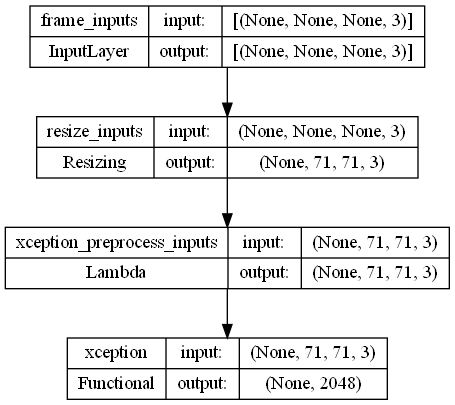

In [33]:
preprocess_and_xception = tf.keras.Sequential(name='preprocess_and_xception')

preprocess_and_xception.add(tf.keras.Input(shape=(None, None, 3), name='frame_inputs'))
preprocess_and_xception.add(
    tf.keras.layers.Resizing(XCEPTION_resize_height, XCEPTION_resize_width, name='resize_inputs'))
preprocess_and_xception.add(
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input, name='xception_preprocess_inputs'))
xception_model = tf.keras.applications.Xception(weights='imagenet',
                                                input_shape=(XCEPTION_resize_height, XCEPTION_resize_width, 3),
                                                include_top=False, pooling='avg')
xception_model.trainable = False
preprocess_and_xception.add(xception_model)

tf.keras.utils.plot_model(preprocess_and_xception, "preprocess_and_xception.png", show_shapes=True)

In [34]:
# def build_mobilenet():
#     resiz = tf.keras.layers.Resizing(XCEPTION_resize_height, XCEPTION_resize_width)
#     preprocessed_inputs1l=tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
#     model1=tf.keras.applications.Xception(weights='imagenet', include_top=False, pooling='avg')
#     model1.trainable = False
#     model1=tf.keras.Sequential([resiz, preprocessed_inputs1l, model1])
#     return model1
# 
# def action_model(nbout=3):
#     convnet = build_mobilenet()
# 
#     model = tf.keras.Sequential()
#     model.add(tf.keras.Input(shape=(TRAIN_TIME_STEPS, None, None, 3)))
#     model.add(tf.keras.layers.TimeDistributed(convnet))
#     model.add(tf.keras.layers.LSTM(64))
#     model.add(tf.keras.layers.Dense(nbout, activation='softmax'))
#     return model
# 
# model = action_model()
# 
# tf.keras.utils.plot_model(model, "test lstm.png", show_shapes=True)

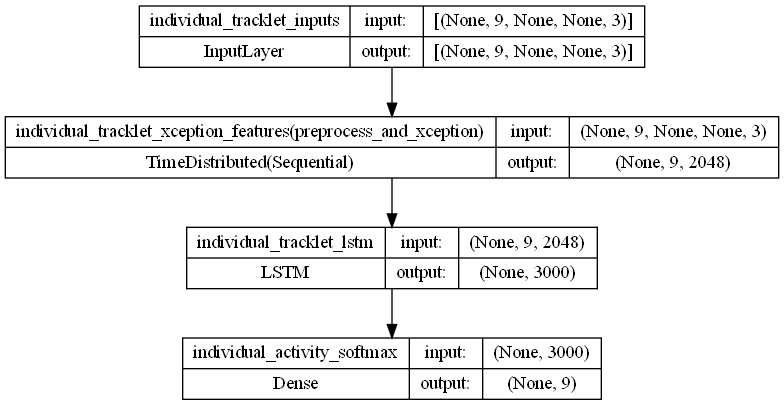

In [35]:
individual_lstm_model = tf.keras.Sequential(name='individual_lstm_model')

individual_lstm_model.add(tf.keras.Input(shape=(TRAIN_TIME_STEPS, None, None, 3), name="individual_tracklet_inputs"))
individual_lstm_model.add(
    tf.keras.layers.TimeDistributed(preprocess_and_xception, name="individual_tracklet_xception_features"))
individual_lstm_model.add(tf.keras.layers.LSTM(3000, name="individual_tracklet_lstm"))
individual_lstm_model.add(tf.keras.layers.Dense(len(all_individual_activity_annotations), activation='softmax',
                                                name="individual_activity_softmax"))

tf.keras.utils.plot_model(individual_lstm_model, "individual_lstm_model.png", show_shapes=True)

In [53]:
# len(X_train_individual_LSTM_unprocessed) = 2697
# for idx, x in enumerate(X_train_individual_LSTM_unprocessed):
#     if len(x) != TRAIN_TIME_STEPS:
#         print(idx)
#         break
# X_train_individual_LSTM_unprocessed[0][4].shape = [None, None, 3]
# for idx, x in enumerate(X_train_individual_LSTM_unprocessed):
#     for idx2, f in enumerate(x):
#         if f.shape[-1] != 3:
#             print(f"{idx}:{idx2}")
#             break
# for idx, x in enumerate(X_train_individual_LSTM_unprocessed):
#     for idx2, f in enumerate(x):
#         if len(f.shape) != 3:
#             print(f"{idx}:{idx2}")
#             break
# X_train_individual_LSTM_unprocessed = np.array(X_train_individual_LSTM_unprocessed)


In [39]:
# TODO can fine tune xception
individual_lstm_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'categorical_crossentropy']
)
# can use validation_split=0.1 here
individual_training_history = individual_lstm_model.fit(x=np.array(X_train_individual_LSTM_unprocessed),
                                                        y=Y_train_individual_LSTM,
                                                        epochs=5
                                                        )

ValueError: Data cardinality is ambiguous:
  x sizes: 130, 130, 130, 130, 130, 130, 130, 130, 130, 124, 124, 124, 124, 124, 124, 124, 124, 124, 159, 159, 159, 159, 159, 159, 159, 159, 159, 131, 131, 131, 131, 131, 131, 131, 131, 131, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 149, 149, 149, 149, 149, 149, 149, 149, 149, 180, 180, 180, 180, 180, 180, 180, 180, 180, 176, 176, 176, 176, 176, 176, 176, 176, 176, 149, 149, 149, 149, 149, 149, 149, 149, 149, 159, 159, 159, 159, 159, 159, 159, 159, 159, 151, 151, 151, 151, 151, 151, 151, 151, 151, 55, 55, 55, 55, 55, 55, 55, 55, 55, 114, 114, 114, 114, 114, 114, 114, 114, 114, 150, 150, 150, 150, 150, 150, 150, 150, 150, 113, 113, 113, 113, 113, 113, 113, 113, 113, 116, 116, 116, 116, 116, 116, 116, 116, 116, 125, 125, 125, 125, 125, 125, 125, 125, 125, 128, 128, 128, 128, 128, 128, 128, 128, 128, 133, 133, 133, 133, 133, 133, 133, 133, 133, 119, 119, 119, 119, 119, 119, 119, 119, 119, 128, 128, 128, 128, 128, 128, 128, 128, 128, 120, 120, 120, 120, 120, 120, 120, 120, 120, 123, 123, 123, 123, 123, 123, 123, 123, 123, 148, 148, 148, 148, 148, 148, 148, 148, 148, 142, 142, 142, 142, 142, 142, 142, 142, 142, 144, 144, 144, 144, 144, 144, 144, 144, 144, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 144, 144, 144, 144, 144, 144, 144, 144, 144, 171, 171, 171, 171, 171, 171, 171, 171, 171, 167, 167, 167, 167, 167, 167, 167, 167, 167, 157, 157, 157, 157, 157, 157, 157, 157, 157, 145, 145, 145, 145, 145, 145, 145, 145, 145, 162, 162, 162, 162, 162, 162, 162, 162, 162, 139, 139, 139, 139, 139, 139, 139, 139, 139, 135, 135, 135, 135, 135, 135, 135, 135, 135, 118, 118, 118, 118, 118, 118, 118, 118, 118, 128, 128, 128, 128, 128, 128, 128, 128, 128, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 157, 157, 157, 157, 157, 157, 157, 157, 157, 152, 152, 152, 152, 152, 152, 152, 152, 152, 132, 132, 132, 132, 132, 132, 132, 132, 132, 128, 128, 128, 128, 128, 128, 128, 128, 128, 182, 182, 182, 182, 182, 182, 182, 182, 182, 144, 144, 144, 144, 144, 144, 144, 144, 144, 148, 148, 148, 148, 148, 148, 148, 148, 148, 175, 175, 175, 175, 175, 175, 175, 175, 175, 131, 131, 131, 131, 131, 131, 131, 131, 131, 172, 172, 172, 172, 172, 172, 172, 172, 172, 147, 147, 147, 147, 147, 147, 147, 147, 147, 184, 184, 184, 184, 184, 184, 184, 184, 184, 183, 183, 183, 183, 183, 183, 183, 183, 183, 177, 177, 177, 177, 177, 177, 177, 177, 177, 176, 176, 176, 176, 176, 176, 176, 176, 176, 136, 136, 136, 136, 136, 136, 136, 136, 136, 158, 158, 158, 158, 158, 158, 158, 158, 158, 143, 143, 143, 143, 143, 143, 143, 143, 143, 177, 177, 177, 177, 177, 177, 177, 177, 177, 164, 164, 164, 164, 164, 164, 164, 164, 164, 151, 151, 151, 151, 151, 151, 151, 151, 151, 133, 133, 133, 133, 133, 133, 133, 133, 133, 154, 154, 154, 154, 154, 154, 154, 154, 154, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 157, 157, 157, 157, 157, 157, 157, 157, 157, 140, 140, 140, 140, 140, 140, 140, 140, 140, 159, 159, 159, 159, 159, 159, 159, 159, 159, 161, 161, 161, 161, 161, 161, 161, 161, 161, 118, 118, 118, 118, 118, 118, 118, 118, 118, 156, 156, 156, 156, 156, 156, 156, 156, 156, 158, 158, 158, 158, 158, 158, 158, 158, 158, 163, 163, 163, 163, 163, 163, 163, 163, 163, 169, 169, 169, 169, 169, 169, 169, 169, 169, 175, 175, 175, 175, 175, 175, 175, 175, 175, 161, 161, 161, 161, 161, 161, 161, 161, 161, 158, 158, 158, 158, 158, 158, 158, 158, 158, 160, 160, 160, 160, 160, 160, 160, 160, 160, 140, 140, 140, 140, 140, 140, 140, 140, 140, 163, 163, 163, 163, 163, 163, 163, 163, 163, 131, 131, 131, 131, 131, 131, 131, 131, 131, 103, 103, 103, 103, 103, 103, 103, 103, 103, 157, 157, 157, 157, 157, 157, 157, 157, 157, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 115, 115, 115, 115, 115, 115, 115, 115, 115, 132, 132, 132, 132, 132, 132, 132, 132, 132, 165, 165, 165, 165, 165, 165, 165, 165, 165, 178, 178, 178, 178, 178, 178, 178, 178, 178, 164, 164, 164, 164, 164, 164, 164, 164, 164, 147, 147, 147, 147, 147, 147, 147, 147, 147, 133, 133, 133, 133, 133, 133, 133, 133, 133, 161, 161, 161, 161, 161, 161, 161, 161, 161, 168, 168, 168, 168, 168, 168, 168, 168, 168, 150, 150, 150, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151, 151, 151, 151, 151, 151, 135, 135, 135, 135, 135, 135, 135, 135, 135, 152, 152, 152, 152, 152, 152, 152, 152, 152, 166, 166, 166, 166, 166, 166, 166, 166, 166, 149, 149, 149, 149, 149, 149, 149, 149, 149, 142, 142, 142, 142, 142, 142, 142, 142, 142, 128, 128, 128, 128, 128, 128, 128, 128, 128, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 147, 147, 147, 147, 147, 147, 147, 147, 147, 157, 157, 157, 157, 157, 157, 157, 157, 157, 168, 168, 168, 168, 168, 168, 168, 168, 168, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 96, 96, 96, 96, 96, 96, 96, 96, 96, 186, 186, 186, 186, 186, 186, 186, 186, 186, 160, 160, 160, 160, 160, 160, 160, 160, 160, 148, 148, 148, 148, 148, 148, 148, 148, 148, 78, 78, 78, 78, 78, 78, 78, 78, 78, 147, 147, 147, 147, 147, 147, 147, 147, 147, 136, 136, 136, 136, 136, 136, 136, 136, 136, 154, 154, 154, 154, 154, 154, 154, 154, 154, 174, 174, 174, 174, 174, 174, 174, 174, 174, 162, 162, 162, 162, 162, 162, 162, 162, 162, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 123, 123, 123, 123, 123, 123, 123, 123, 123, 154, 154, 154, 154, 154, 154, 154, 154, 154, 173, 173, 173, 173, 173, 173, 173, 173, 173, 170, 170, 170, 170, 170, 170, 170, 170, 170, 141, 141, 141, 141, 141, 141, 141, 141, 141, 134, 134, 134, 134, 134, 134, 134, 134, 134, 187, 187, 187, 187, 187, 187, 187, 187, 187, 166, 166, 166, 166, 166, 166, 166, 166, 166, 164, 164, 164, 164, 164, 164, 164, 164, 164, 127, 127, 127, 127, 127, 127, 127, 127, 127, 151, 151, 151, 151, 151, 151, 151, 151, 151, 144, 144, 144, 144, 144, 144, 144, 144, 144, 137, 137, 137, 137, 137, 137, 137, 137, 137, 134, 134, 134, 134, 134, 134, 134, 134, 134, 158, 158, 158, 158, 158, 158, 158, 158, 158, 145, 145, 145, 145, 145, 145, 145, 145, 145, 163, 163, 163, 163, 163, 163, 163, 163, 163, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 137, 137, 137, 137, 137, 137, 137, 137, 137, 142, 142, 142, 142, 142, 142, 142, 142, 142, 155, 155, 155, 155, 155, 155, 155, 155, 155, 116, 116, 116, 116, 116, 116, 116, 116, 116, 124, 124, 124, 124, 124, 124, 124, 124, 124, 132, 132, 132, 132, 132, 132, 132, 132, 132, 153, 153, 153, 153, 153, 153, 153, 153, 153, 164, 164, 164, 164, 164, 164, 164, 164, 164, 129, 129, 129, 129, 129, 129, 129, 129, 129, 136, 136, 136, 136, 136, 136, 136, 136, 136, 122, 122, 122, 122, 122, 122, 122, 122, 122, 130, 130, 130, 130, 130, 130, 130, 130, 130, 108, 108, 108, 108, 108, 108, 108, 108, 108, 101, 101, 101, 101, 101, 101, 101, 101, 101, 138, 138, 138, 138, 138, 138, 138, 138, 138, 135, 135, 135, 135, 135, 135, 135, 135, 135, 162, 162, 162, 162, 162, 162, 162, 162, 162, 148, 148, 148, 148, 148, 148, 148, 148, 148, 135, 135, 135, 135, 135, 135, 135, 135, 135, 161, 161, 161, 161, 161, 161, 161, 161, 161, 139, 139, 139, 139, 139, 139, 139, 139, 139, 137, 137, 137, 137, 137, 137, 137, 137, 137, 59, 59, 59, 59, 59, 59, 59, 59, 59, 120, 120, 120, 120, 120, 120, 120, 120, 120, 158, 158, 158, 158, 158, 158, 158, 158, 158, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 131, 131, 131, 131, 131, 131, 131, 131, 131, 130, 130, 130, 130, 130, 130, 130, 130, 130, 142, 142, 142, 142, 142, 142, 142, 142, 142, 120, 120, 120, 120, 120, 120, 120, 120, 120, 114, 114, 114, 114, 114, 114, 114, 114, 114, 150, 150, 150, 150, 150, 150, 150, 150, 150, 130, 130, 130, 130, 130, 130, 130, 130, 130, 116, 116, 116, 116, 116, 116, 116, 116, 116, 106, 106, 106, 106, 106, 106, 106, 106, 106, 117, 117, 117, 117, 117, 117, 117, 117, 117, 179, 179, 179, 179, 179, 179, 179, 179, 179, 110, 110, 110, 110, 110, 110, 110, 110, 110, 92, 92, 92, 92, 92, 92, 92, 92, 92, 80, 80, 80, 80, 80, 80, 80, 80, 80, 145, 145, 145, 145, 145, 145, 145, 145, 145, 105, 105, 105, 105, 105, 105, 105, 105, 105, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 121, 121, 121, 121, 121, 121, 121, 121, 121, 119, 119, 119, 119, 119, 119, 119, 119, 119, 110, 110, 110, 110, 110, 110, 110, 110, 110, 132, 132, 132, 132, 132, 132, 132, 132, 132, 112, 112, 112, 112, 112, 112, 112, 112, 112, 139, 139, 139, 139, 139, 139, 139, 139, 139, 120, 120, 120, 120, 120, 120, 120, 120, 120, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 105, 105, 105, 105, 105, 105, 105, 105, 105, 150, 150, 150, 150, 150, 150, 150, 150, 150, 175, 175, 175, 175, 175, 175, 175, 175, 175, 165, 165, 165, 165, 165, 165, 165, 165, 165, 161, 161, 161, 161, 161, 161, 161, 161, 161, 147, 147, 147, 147, 147, 147, 147, 147, 147, 113, 113, 113, 113, 113, 113, 113, 113, 113, 133, 133, 133, 133, 133, 133, 133, 133, 133, 92, 92, 92, 92, 92, 92, 92, 92, 92, 160, 160, 160, 160, 160, 160, 160, 160, 160, 139, 139, 139, 139, 139, 139, 139, 139, 139, 106, 106, 106, 106, 106, 106, 106, 106, 106, 115, 115, 115, 115, 115, 115, 115, 115, 115, 127, 127, 127, 127, 127, 127, 127, 127, 127, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 141, 141, 141, 141, 141, 141, 141, 159, 159, 159, 159, 159, 159, 159, 159, 159, 155, 155, 155, 155, 155, 155, 155, 155, 155, 146, 146, 146, 146, 146, 146, 146, 146, 146, 141, 141, 141, 141, 141, 141, 141, 141, 141, 113, 113, 113, 113, 113, 113, 113, 113, 113, 120, 120, 120, 120, 120, 120, 120, 120, 120, 196, 196, 196, 196, 196, 196, 196, 196, 196, 130, 130, 130, 130, 130, 130, 130, 130, 130, 121, 121, 121, 121, 121, 121, 121, 121, 121, 117, 117, 117, 117, 117, 117, 117, 117, 117, 130, 130, 130, 130, 130, 130, 130, 130, 130, 100, 100, 100, 100, 100, 100, 100, 100, 100, 109, 109, 109, 109, 109, 109, 109, 109, 109, 141, 141, 141, 141, 141, 141, 141, 141, 141, 204, 204, 204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 123, 123, 123, 123, 123, 123, 123, 123, 123, 149, 149, 149, 149, 149, 149, 149, 149, 149, 138, 138, 138, 138, 138, 138, 138, 138, 138, 135, 135, 135, 135, 135, 135, 135, 135, 135, 172, 172, 172, 172, 172, 172, 172, 172, 172, 132, 132, 132, 132, 132, 132, 132, 132, 132, 142, 142, 142, 142, 142, 142, 142, 142, 142, 154, 154, 154, 154, 154, 154, 154, 154, 154, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 159, 159, 159, 159, 159, 159, 159, 159, 159, 113, 113, 113, 113, 113, 113, 113, 113, 113, 136, 136, 136, 136, 136, 136, 136, 136, 136, 125, 125, 125, 125, 125, 125, 125, 125, 125, 148, 148, 148, 148, 148, 148, 148, 148, 148, 142, 142, 142, 142, 142, 142, 142, 142, 142, 125, 125, 125, 125, 125, 125, 125, 125, 125, 133, 133, 133, 133, 133, 133, 133, 133, 133, 147, 147, 147, 147, 147, 147, 147, 147, 147, 111, 111, 111, 111, 111, 111, 111, 111, 111, 134, 134, 134, 134, 134, 134, 134, 134, 134, 151, 151, 151, 151, 151, 151, 151, 151, 151, 131, 131, 131, 131, 131, 131, 131, 131, 131, 123, 123, 123, 123, 123, 123, 123, 123, 123, 142, 142, 142, 142, 142, 142, 142, 142, 142, 140, 140, 140, 140, 140, 140, 140, 140, 140, 117, 117, 117, 117, 117, 117, 117, 117, 117, 140, 140, 140, 140, 140, 140, 140, 140, 140, 119, 119, 119, 119, 119, 119, 119, 119, 119, 147, 147, 147, 147, 147, 147, 147, 147, 147, 126, 126, 126, 126, 126, 126, 126, 126, 126, 128, 128, 128, 128, 128, 128, 128, 128, 128, 172, 172, 172, 172, 172, 172, 172, 172, 172, 130, 130, 130, 130, 130, 130, 130, 130, 130, 102, 102, 102, 102, 102, 102, 102, 102, 102, 106, 106, 106, 106, 106, 106, 106, 106, 106, 198, 198, 198, 198, 198, 198, 198, 198, 198, 87, 87, 87, 87, 87, 87, 87, 87, 87, 130, 130, 130, 130, 130, 130, 130, 130, 130, 100, 100, 100, 100, 100, 100, 100, 100, 100, 113, 113, 113, 113, 113, 113, 113, 113, 113, 140, 140, 140, 140, 140, 140, 140, 140, 140, 202, 202, 202, 202, 202, 202, 202, 202, 202, 120, 120, 120, 120, 120, 120, 120, 120, 120, 205, 205, 205, 205, 205, 205, 205, 205, 205, 165, 165, 165, 165, 165, 165, 165, 165, 165, 135, 135, 135, 135, 135, 135, 135, 135, 135, 99, 99, 99, 99, 99, 99, 99, 99, 99, 125, 125, 125, 125, 125, 125, 125, 125, 125, 134, 134, 134, 134, 134, 134, 134, 134, 134, 129, 129, 129, 129, 129, 129, 129, 129, 129, 142, 142, 142, 142, 142, 142, 142, 142, 142, 112, 112, 112, 112, 112, 112, 112, 112, 112, 90, 90, 90, 90, 90, 90, 90, 90, 90, 104, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 105, 105, 105, 148, 148, 148, 148, 148, 148, 148, 148, 148, 126, 126, 126, 126, 126, 126, 126, 126, 126, 140, 140, 140, 140, 140, 140, 140, 140, 140, 148, 148, 148, 148, 148, 148, 148, 148, 148, 136, 136, 136, 136, 136, 136, 136, 136, 136, 127, 127, 127, 127, 127, 127, 127, 127, 127, 137, 137, 137, 137, 137, 137, 137, 137, 137, 98, 98, 98, 98, 98, 98, 98, 98, 98, 142, 142, 142, 142, 142, 142, 142, 142, 142, 107, 107, 107, 107, 107, 107, 107, 107, 107, 136, 136, 136, 136, 136, 136, 136, 136, 136, 132, 132, 132, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133, 133, 133, 133, 133, 133, 117, 117, 117, 117, 117, 117, 117, 117, 117, 87, 87, 87, 87, 87, 87, 87, 87, 87, 119, 119, 119, 119, 119, 119, 119, 119, 119, 130, 130, 130, 130, 130, 130, 130, 130, 130, 116, 116, 116, 116, 116, 116, 116, 116, 116, 163, 163, 163, 163, 163, 163, 163, 163, 163, 120, 120, 120, 120, 120, 120, 120, 120, 120, 99, 99, 99, 99, 99, 99, 99, 99, 99, 128, 128, 128, 128, 128, 128, 128, 128, 128, 119, 119, 119, 119, 119, 119, 119, 119, 119, 92, 92, 92, 92, 92, 92, 92, 92, 92, 140, 140, 140, 140, 140, 140, 140, 140, 140, 133, 133, 133, 133, 133, 133, 133, 133, 133, 112, 112, 112, 112, 112, 112, 112, 112, 112, 161, 161, 161, 161, 161, 161, 161, 161, 161, 175, 175, 175, 175, 175, 175, 175, 175, 175, 123, 123, 123, 123, 123, 123, 123, 123, 123, 161, 161, 161, 161, 161, 161, 161, 161, 161, 154, 154, 154, 154, 154, 154, 154, 154, 154, 151, 151, 151, 151, 151, 151, 151, 151, 151, 135, 135, 135, 135, 135, 135, 135, 135, 135, 142, 142, 142, 142, 142, 142, 142, 142, 142, 161, 161, 161, 161, 161, 161, 161, 161, 161, 150, 150, 150, 150, 150, 150, 150, 150, 150, 154, 154, 154, 154, 154, 154, 154, 154, 154, 121, 121, 121, 121, 121, 121, 121, 121, 121, 156, 156, 156, 156, 156, 156, 156, 156, 156, 170, 170, 170, 170, 170, 170, 170, 170, 170, 150, 150, 150, 150, 150, 150, 150, 150, 150, 133, 133, 133, 133, 133, 133, 133, 133, 133, 145, 145, 145, 145, 145, 145, 145, 145, 145, 158, 158, 158, 158, 158, 158, 158, 158, 158, 154, 154, 154, 154, 154, 154, 154, 154, 154, 105, 105, 105, 105, 105, 105, 105, 105, 105, 121, 121, 121, 121, 121, 121, 121, 121, 121, 150, 150, 150, 150, 150, 150, 150, 150, 150, 102, 102, 102, 102, 102, 102, 102, 102, 102, 142, 142, 142, 142, 142, 142, 142, 142, 142, 145, 145, 145, 145, 145, 145, 145, 145, 145, 159, 159, 159, 159, 159, 159, 159, 159, 159, 133, 133, 133, 133, 133, 133, 133, 133, 133, 175, 175, 175, 175, 175, 175, 175, 175, 175, 152, 152, 152, 152, 152, 152, 152, 152, 152, 118, 118, 118, 118, 118, 118, 118, 118, 118, 130, 130, 130, 130, 130, 130, 130, 130, 130, 145, 145, 145, 145, 145, 145, 145, 145, 145, 176, 176, 176, 176, 176, 176, 176, 176, 176, 137, 137, 137, 137, 137, 137, 137, 137, 137, 132, 132, 132, 132, 132, 132, 132, 132, 132, 118, 118, 118, 118, 118, 118, 118, 118, 118, 122, 122, 122, 122, 122, 122, 122, 122, 122, 157, 157, 157, 157, 157, 157, 157, 157, 157, 114, 114, 114, 114, 114, 114, 114, 114, 114, 165, 165, 165, 165, 165, 165, 165, 165, 165, 121, 121, 121, 121, 121, 121, 121, 121, 121, 126, 126, 126, 126, 126, 126, 126, 126, 126, 113, 113, 113, 113, 113, 113, 113, 113, 113, 120, 120, 120, 120, 120, 120, 120, 120, 120, 129, 129, 129, 129, 129, 129, 129, 129, 129, 114, 114, 114, 114, 114, 114, 114, 114, 114, 123, 123, 123, 123, 123, 123, 123, 123, 123, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158, 158, 158, 158, 158, 158, 158, 158, 127, 127, 127, 127, 127, 127, 127, 127, 127, 159, 159, 159, 159, 159, 159, 159, 159, 159, 140, 140, 140, 140, 140, 140, 140, 140, 140, 155, 155, 155, 155, 155, 155, 155, 155, 155, 180, 180, 180, 180, 180, 180, 180, 180, 180, 142, 142, 142, 142, 142, 142, 142, 142, 142, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 123, 123, 123, 123, 123, 123, 123, 123, 123, 140, 140, 140, 140, 140, 140, 140, 140, 140, 148, 148, 148, 148, 148, 148, 148, 148, 148, 187, 187, 187, 187, 187, 187, 187, 187, 187, 146, 146, 146, 146, 146, 146, 146, 146, 146, 148, 148, 148, 148, 148, 148, 148, 148, 148, 153, 153, 153, 153, 153, 153, 153, 153, 153, 128, 128, 128, 128, 128, 128, 128, 128, 128, 162, 162, 162, 162, 162, 162, 162, 162, 162, 149, 149, 149, 149, 149, 149, 149, 149, 149, 151, 151, 151, 151, 151, 151, 151, 151, 151, 139, 139, 139, 139, 139, 139, 139, 139, 139, 107, 107, 107, 107, 107, 107, 107, 107, 107, 126, 126, 126, 126, 126, 126, 126, 126, 126, 133, 133, 133, 133, 133, 133, 133, 133, 133, 173, 173, 173, 173, 173, 173, 173, 173, 173, 107, 107, 107, 107, 107, 107, 107, 107, 107, 133, 133, 133, 133, 133, 133, 133, 133, 133, 143, 143, 143, 143, 143, 143, 143, 143, 143, 118, 118, 118, 118, 118, 118, 118, 118, 118, 161, 161, 161, 161, 161, 161, 161, 161, 161, 118, 118, 118, 118, 118, 118, 118, 118, 118, 136, 136, 136, 136, 136, 136, 136, 136, 136, 83, 83, 83, 83, 83, 83, 83, 83, 83, 157, 157, 157, 157, 157, 157, 157, 157, 157, 142, 142, 142, 142, 142, 142, 142, 142, 142, 140, 140, 140, 140, 140, 140, 140, 140, 140, 107, 107, 107, 107, 107, 107, 107, 107, 107, 123, 123, 123, 123, 123, 123, 123, 123, 123, 111, 111, 111, 111, 111, 111, 111, 111, 111, 96, 96, 96, 96, 96, 96, 96, 96, 96, 195, 195, 195, 195, 195, 195, 195, 195, 195, 189, 189, 189, 189, 189, 189, 189, 189, 189, 97, 97, 97, 97, 97, 97, 97, 97, 97, 124, 124, 124, 124, 124, 124, 124, 124, 124, 99, 99, 99, 99, 99, 99, 99, 99, 99, 97, 97, 97, 97, 97, 97, 97, 97, 97, 175, 175, 175, 175, 175, 175, 175, 175, 175, 105, 105, 105, 105, 105, 105, 105, 105, 105, 131, 131, 131, 131, 131, 131, 131, 131, 131, 111, 111, 111, 111, 111, 111, 111, 111, 111, 133, 133, 133, 133, 133, 133, 133, 133, 133, 137, 137, 137, 137, 137, 137, 137, 137, 137, 153, 153, 153, 153, 153, 153, 153, 153, 153, 130, 130, 130, 130, 130, 130, 130, 130, 130, 147, 147, 147, 147, 147, 147, 147, 147, 147, 115, 115, 115, 115, 115, 115, 115, 115, 115, 158, 158, 158, 158, 158, 158, 158, 158, 158, 131, 131, 131, 131, 131, 131, 131, 131, 131, 162, 162, 162, 162, 162, 162, 162, 162, 162, 100, 100, 100, 100, 100, 100, 100, 100, 100, 156, 156, 156, 156, 156, 156, 156, 156, 156, 155, 155, 155, 155, 155, 155, 155, 155, 155, 145, 145, 145, 145, 145, 145, 145, 145, 145, 98, 98, 98, 98, 98, 98, 98, 98, 98, 120, 120, 120, 120, 120, 120, 120, 120, 120, 137, 137, 137, 137, 137, 137, 137, 137, 137, 151, 151, 151, 151, 151, 151, 151, 151, 151, 117, 117, 117, 117, 117, 117, 117, 117, 117, 132, 132, 132, 132, 132, 132, 132, 132, 132, 145, 145, 145, 145, 145, 145, 145, 145, 145, 160, 160, 160, 160, 160, 160, 160, 160, 160, 148, 148, 148, 148, 148, 148, 148, 148, 148, 131, 131, 131, 131, 131, 131, 131, 131, 131, 142, 142, 142, 142, 142, 142, 142, 142, 142, 132, 132, 132, 132, 132, 132, 132, 132, 132, 100, 100, 100, 100, 100, 100, 100, 100, 100, 112, 112, 112, 112, 112, 112, 112, 112, 112, 132, 132, 132, 132, 132, 132, 132, 132, 132, 142, 142, 142, 142, 142, 142, 142, 142, 142, 120, 120, 120, 120, 120, 120, 120, 120, 120, 155, 155, 155, 155, 155, 155, 155, 155, 155, 139, 139, 139, 139, 139, 139, 139, 139, 139, 127, 127, 127, 127, 127, 127, 127, 127, 127, 157, 157, 157, 157, 157, 157, 157, 157, 157, 144, 144, 144, 144, 144, 144, 144, 144, 144, 141, 141, 141, 141, 141, 141, 141, 141, 141, 166, 166, 166, 166, 166, 166, 166, 166, 166, 133, 133, 133, 133, 133, 133, 133, 133, 133, 138, 138, 138, 138, 138, 138, 138, 138, 138, 178, 178, 178, 178, 178, 178, 178, 178, 178, 125, 125, 125, 125, 125, 125, 125, 125, 125, 106, 106, 106, 106, 106, 106, 106, 106, 106, 127, 127, 127, 127, 127, 127, 127, 127, 127, 131, 131, 131, 131, 131, 131, 131, 131, 131, 151, 151, 151, 151, 151, 151, 151, 151, 151, 173, 173, 173, 173, 173, 173, 173, 173, 173, 134, 134, 134, 134, 134, 134, 134, 134, 134, 131, 131, 131, 131, 131, 131, 131, 131, 131, 130, 130, 130, 130, 130, 130, 130, 130, 130, 150, 150, 150, 150, 150, 150, 150, 150, 150, 125, 125, 125, 125, 125, 125, 125, 125, 125, 182, 182, 182, 182, 182, 182, 182, 182, 182, 162, 162, 162, 162, 162, 162, 162, 162, 162, 111, 111, 111, 111, 111, 111, 111, 111, 111, 134, 134, 134, 134, 134, 134, 134, 134, 134, 116, 116, 116, 116, 116, 116, 116, 116, 116, 125, 125, 125, 125, 125, 125, 125, 125, 125, 170, 170, 170, 170, 170, 170, 170, 170, 170, 144, 144, 144, 144, 144, 144, 144, 144, 144, 105, 105, 105, 105, 105, 105, 105, 105, 105, 127, 127, 127, 127, 127, 127, 127, 127, 127, 141, 141, 141, 141, 141, 141, 141, 141, 141, 149, 149, 149, 149, 149, 149, 149, 149, 149, 128, 128, 128, 128, 128, 128, 128, 128, 128, 117, 117, 117, 117, 117, 117, 117, 117, 117, 197, 197, 197, 197, 197, 197, 197, 197, 197, 183, 183, 183, 183, 183, 183, 183, 183, 183, 105, 105, 105, 105, 105, 105, 105, 105, 105, 152, 152, 152, 152, 152, 152, 152, 152, 152, 121, 121, 121, 121, 121, 121, 121, 121, 121, 157, 157, 157, 157, 157, 157, 157, 157, 157, 111, 111, 111, 111, 111, 111, 111, 111, 111, 144, 144, 144, 144, 144, 144, 144, 144, 144, 130, 130, 130, 130, 130, 130, 130, 130, 130, 106, 106, 106, 106, 106, 106, 106, 106, 106, 89, 89, 89, 89, 89, 89, 89, 89, 89, 142, 142, 142, 142, 142, 142, 142, 142, 142, 138, 138, 138, 138, 138, 138, 138, 138, 138, 67, 67, 67, 67, 67, 67, 67, 67, 67, 89, 89, 89, 89, 89, 89, 89, 89, 89, 132, 132, 132, 132, 132, 132, 132, 132, 132, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 161, 161, 161, 161, 161, 161, 161, 161, 161, 145, 145, 145, 145, 145, 145, 145, 145, 145, 158, 158, 158, 158, 158, 158, 158, 158, 158, 164, 164, 164, 164, 164, 164, 164, 164, 164, 180, 180, 180, 180, 180, 180, 180, 180, 180, 150, 150, 150, 150, 150, 150, 150, 150, 150, 135, 135, 135, 135, 135, 135, 135, 135, 135, 112, 112, 112, 112, 112, 112, 112, 112, 112, 126, 126, 126, 126, 126, 126, 126, 126, 126, 103, 103, 103, 103, 103, 103, 103, 103, 103, 196, 196, 196, 196, 196, 196, 196, 196, 196, 183, 183, 183, 183, 183, 183, 183, 183, 183, 133, 133, 133, 133, 133, 133, 133, 133, 133, 178, 178, 178, 178, 178, 178, 178, 178, 178, 147, 147, 147, 147, 147, 147, 147, 147, 147, 137, 137, 137, 137, 137, 137, 137, 137, 137, 150, 150, 150, 150, 150, 150, 150, 150, 150, 160, 160, 160, 160, 160, 160, 160, 160, 160, 170, 170, 170, 170, 170, 170, 170, 170, 170, 176, 176, 176, 176, 176, 176, 176, 176, 176, 162, 162, 162, 162, 162, 162, 162, 162, 162, 117, 117, 117, 117, 117, 117, 117, 117, 117, 158, 158, 158, 158, 158, 158, 158, 158, 158, 137, 137, 137, 137, 137, 137, 137, 137, 137, 148, 148, 148, 148, 148, 148, 148, 148, 148, 152, 152, 152, 152, 152, 152, 152, 152, 152, 182, 182, 182, 182, 182, 182, 182, 182, 182, 139, 139, 139, 139, 139, 139, 139, 139, 139, 112, 112, 112, 112, 112, 112, 112, 112, 112, 148, 148, 148, 148, 148, 148, 148, 148, 148, 120, 120, 120, 120, 120, 120, 120, 120, 120, 97, 97, 97, 97, 97, 97, 97, 97, 97, 137, 137, 137, 137, 137, 137, 137, 137, 137, 118, 118, 118, 118, 118, 118, 118, 118, 118, 127, 127, 127, 127, 127, 127, 127, 127, 127, 149, 149, 149, 149, 149, 149, 149, 149, 149, 143, 143, 143, 143, 143, 143, 143, 143, 143, 127, 127, 127, 127, 127, 127, 127, 127, 127, 124, 124, 124, 124, 124, 124, 124, 124, 124, 119, 119, 119, 119, 119, 119, 119, 119, 119, 163, 163, 163, 163, 163, 163, 163, 163, 163, 160, 160, 160, 160, 160, 160, 160, 160, 160, 148, 148, 148, 148, 148, 148, 148, 148, 148, 113, 113, 113, 113, 113, 113, 113, 113, 113, 141, 141, 141, 141, 141, 141, 141, 141, 141, 144, 144, 144, 144, 144, 144, 144, 144, 144, 157, 157, 157, 157, 157, 157, 157, 157, 157, 151, 151, 151, 151, 151, 151, 151, 151, 151, 121, 121, 121, 121, 121, 121, 121, 121, 121, 101, 101, 101, 101, 101, 101, 101, 101, 101, 150, 150, 150, 150, 150, 150, 150, 150, 150, 124, 124, 124, 124, 124, 124, 124, 124, 124, 128, 128, 128, 128, 128, 128, 128, 128, 128, 145, 145, 145, 145, 145, 145, 145, 145, 145, 106, 106, 106, 106, 106, 106, 106, 106, 106, 116, 116, 116, 116, 116, 116, 116, 116, 116, 135, 135, 135, 135, 135, 135, 135, 135, 135, 152, 152, 152, 152, 152, 152, 152, 152, 152, 125, 125, 125, 125, 125, 125, 125, 125, 125, 139, 139, 139, 139, 139, 139, 139, 139, 139, 169, 169, 169, 169, 169, 169, 169, 169, 169, 117, 117, 117, 117, 117, 117, 117, 117, 117, 128, 128, 128, 128, 128, 128, 128, 128, 128, 139, 139, 139, 139, 139, 139, 139, 139, 139, 128, 128, 128, 128, 128, 128, 128, 128, 128, 121, 121, 121, 121, 121, 121, 121, 121, 121, 132, 132, 132, 132, 132, 132, 132, 132, 132, 204, 204, 204, 204, 204, 204, 204, 204, 204, 144, 144, 144, 144, 144, 144, 144, 144, 144, 139, 139, 139, 139, 139, 139, 139, 139, 139, 114, 114, 114, 114, 114, 114, 114, 114, 114, 118, 118, 118, 118, 118, 118, 118, 118, 118, 161, 161, 161, 161, 161, 161, 161, 161, 161, 131, 131, 131, 131, 131, 131, 131, 131, 131, 122, 122, 122, 122, 122, 122, 122, 122, 122, 116, 116, 116, 116, 116, 116, 116, 116, 116, 120, 120, 120, 120, 120, 120, 120, 120, 120, 124, 124, 124, 124, 124, 124, 124, 124, 124, 133, 133, 133, 133, 133, 133, 133, 133, 133, 103, 103, 103, 103, 103, 103, 103, 103, 103, 122, 122, 122, 122, 122, 122, 122, 122, 122, 142, 142, 142, 142, 142, 142, 142, 142, 142, 130, 130, 130, 130, 130, 130, 130, 130, 130, 142, 142, 142, 142, 142, 142, 142, 142, 142, 133, 133, 133, 133, 133, 133, 133, 133, 133, 148, 148, 148, 148, 148, 148, 148, 148, 148, 156, 156, 156, 156, 156, 156, 156, 156, 156, 108, 108, 108, 108, 108, 108, 108, 108, 108, 128, 128, 128, 128, 128, 128, 128, 128, 128, 97, 97, 97, 97, 97, 97, 97, 97, 97, 148, 148, 148, 148, 148, 148, 148, 148, 148, 111, 111, 111, 111, 111, 111, 111, 111, 111, 117, 117, 117, 117, 117, 117, 117, 117, 117, 114, 114, 114, 114, 114, 114, 114, 114, 114, 155, 155, 155, 155, 155, 155, 155, 155, 155, 84, 84, 84, 84, 84, 84, 84, 84, 84, 126, 126, 126, 126, 126, 126, 126, 126, 126, 102, 102, 102, 102, 102, 102, 102, 102, 102, 127, 127, 127, 127, 127, 127, 127, 127, 127, 134, 134, 134, 134, 134, 134, 134, 134, 134, 102, 102, 102, 102, 102, 102, 102, 102, 102, 169, 169, 169, 169, 169, 169, 169, 169, 169, 161, 161, 161, 161, 161, 161, 161, 161, 161, 110, 110, 110, 110, 110, 110, 110, 110, 110, 131, 131, 131, 131, 131, 131, 131, 131, 131, 156, 156, 156, 156, 156, 156, 156, 156, 156, 123, 123, 123, 123, 123, 123, 123, 123, 123, 133, 133, 133, 133, 133, 133, 133, 133, 133, 161, 161, 161, 161, 161, 161, 161, 161, 161, 154, 154, 154, 154, 154, 154, 154, 154, 154, 103, 103, 103, 103, 103, 103, 103, 103, 103, 142, 142, 142, 142, 142, 142, 142, 142, 142, 145, 145, 145, 145, 145, 145, 145, 145, 145, 175, 175, 175, 175, 175, 175, 175, 175, 175, 150, 150, 150, 150, 150, 150, 150, 150, 150, 103, 103, 103, 103, 103, 103, 103, 103, 103, 144, 144, 144, 144, 144, 144, 144, 144, 144, 125, 125, 125, 125, 125, 125, 125, 125, 125, 90, 90, 90, 90, 90, 90, 90, 90, 90, 111, 111, 111, 111, 111, 111, 111, 111, 111, 97, 97, 97, 97, 97, 97, 97, 97, 97, 107, 107, 107, 107, 107, 107, 107, 107, 107, 153, 153, 153, 153, 153, 153, 153, 153, 153, 124, 124, 124, 124, 124, 124, 124, 124, 124, 119, 119, 119, 119, 119, 119, 119, 119, 119, 134, 134, 134, 134, 134, 134, 134, 134, 134, 105, 105, 105, 105, 105, 105, 105, 105, 105, 113, 113, 113, 113, 113, 113, 113, 113, 113, 102, 102, 102, 102, 102, 102, 102, 102, 102, 97, 97, 97, 97, 97, 97, 97, 97, 97, 154, 154, 154, 154, 154, 154, 154, 154, 154, 161, 161, 161, 161, 161, 161, 161, 161, 161, 117, 117, 117, 117, 117, 117, 117, 117, 117, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 173, 173, 173, 173, 173, 173, 173, 173, 173, 141, 141, 141, 141, 141, 141, 141, 141, 141, 148, 148, 148, 148, 148, 148, 148, 148, 148, 114, 114, 114, 114, 114, 114, 114, 114, 114, 144, 144, 144, 144, 144, 144, 144, 144, 144, 151, 151, 151, 151, 151, 151, 151, 151, 151, 114, 114, 114, 114, 114, 114, 114, 114, 114, 131, 131, 131, 131, 131, 131, 131, 131, 131, 99, 99, 99, 99, 99, 99, 99, 99, 99, 147, 147, 147, 147, 147, 147, 147, 147, 147, 101, 101, 101, 101, 101, 101, 101, 101, 101, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 170, 170, 170, 170, 170, 170, 170, 170, 170, 114, 114, 114, 114, 114, 114, 114, 114, 114, 137, 137, 137, 137, 137, 137, 137, 137, 137, 114, 114, 114, 114, 114, 114, 114, 114, 114, 128, 128, 128, 128, 128, 128, 128, 128, 128, 141, 141, 141, 141, 141, 141, 141, 141, 141, 113, 113, 113, 113, 113, 113, 113, 113, 113, 110, 110, 110, 110, 110, 110, 110, 110, 110, 97, 97, 97, 97, 97, 97, 97, 97, 97, 182, 182, 182, 182, 182, 182, 182, 182, 182, 179, 179, 179, 179, 179, 179, 179, 179, 179, 102, 102, 102, 102, 102, 102, 102, 102, 102, 96, 96, 96, 96, 96, 96, 96, 96, 96, 110, 110, 110, 110, 110, 110, 110, 110, 110, 119, 119, 119, 119, 119, 119, 119, 119, 119, 134, 134, 134, 134, 134, 134, 134, 134, 134, 159, 159, 159, 159, 159, 159, 159, 159, 159, 136, 136, 136, 136, 136, 136, 136, 136, 136, 142, 142, 142, 142, 142, 142, 142, 142, 142, 153, 153, 153, 153, 153, 153, 153, 153, 153, 148, 148, 148, 148, 148, 148, 148, 148, 148, 172, 172, 172, 172, 172, 172, 172, 172, 172, 151, 151, 151, 151, 151, 151, 151, 151, 151, 235, 235, 235, 235, 235, 235, 235, 235, 235, 108, 108, 108, 108, 108, 108, 108, 108, 108, 105, 105, 105, 105, 105, 105, 105, 105, 105, 127, 127, 127, 127, 127, 127, 127, 127, 127, 137, 137, 137, 137, 137, 137, 137, 137, 137, 198, 198, 198, 198, 198, 198, 198, 198, 198, 97, 97, 97, 97, 97, 97, 97, 97, 97, 156, 156, 156, 156, 156, 156, 156, 156, 156, 148, 148, 148, 148, 148, 148, 148, 148, 148, 103, 103, 103, 103, 103, 103, 103, 103, 103, 141, 141, 141, 141, 141, 141, 141, 141, 141, 110, 110, 110, 110, 110, 110, 110, 110, 110, 168, 168, 168, 168, 168, 168, 168, 168, 168, 141, 141, 141, 141, 141, 141, 141, 141, 141, 167, 167, 167, 167, 167, 167, 167, 167, 167, 141, 141, 141, 141, 141, 141, 141, 141, 141, 120, 120, 120, 120, 120, 120, 120, 120, 120, 145, 145, 145, 145, 145, 145, 145, 145, 145, 184, 184, 184, 184, 184, 184, 184, 184, 184, 165, 165, 165, 165, 165, 165, 165, 165, 165, 139, 139, 139, 139, 139, 139, 139, 139, 139, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 187, 187, 187, 187, 187, 187, 187, 187, 187, 165, 165, 165, 165, 165, 165, 165, 165, 165, 139, 139, 139, 139, 139, 139, 139, 139, 139, 131, 131, 131, 131, 131, 131, 131, 131, 131, 112, 112, 112, 112, 112, 112, 112, 112, 112, 136, 136, 136, 136, 136, 136, 136, 136, 136, 184, 184, 184, 184, 184, 184, 184, 184, 184, 177, 177, 177, 177, 177, 177, 177, 177, 177, 135, 135, 135, 135, 135, 135, 135, 135, 135, 163, 163, 163, 163, 163, 163, 163, 163, 163, 158, 158, 158, 158, 158, 158, 158, 158, 158, 151, 151, 151, 151, 151, 151, 151, 151, 151, 173, 173, 173, 173, 173, 173, 173, 173, 173, 127, 127, 127, 127, 127, 127, 127, 127, 127, 135, 135, 135, 135, 135, 135, 135, 135, 135, 143, 143, 143, 143, 143, 143, 143, 143, 143, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 114, 114, 114, 114, 114, 114, 114, 114, 114, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 137, 137, 137, 137, 137, 137, 137, 137, 137, 133, 133, 133, 133, 133, 133, 133, 133, 133, 158, 158, 158, 158, 158, 158, 158, 158, 158, 190, 190, 190, 190, 190, 190, 190, 190, 190, 165, 165, 165, 165, 165, 165, 165, 165, 165, 97, 97, 97, 97, 97, 97, 97, 97, 97, 203, 203, 203, 203, 203, 203, 203, 203, 203, 91, 91, 91, 91, 91, 91, 91, 91, 91, 101, 101, 101, 101, 101, 101, 101, 101, 101, 158, 158, 158, 158, 158, 158, 158, 158, 158, 153, 153, 153, 153, 153, 153, 153, 153, 153, 111, 111, 111, 111, 111, 111, 111, 111, 111, 145, 145, 145, 145, 145, 145, 145, 145, 145, 122, 122, 122, 122, 122, 122, 122, 122, 122, 185, 185, 185, 185, 185, 185, 185, 185, 185, 147, 147, 147, 147, 147, 147, 147, 147, 147, 123, 123, 123, 123, 123, 123, 123, 123, 123, 164, 164, 164, 164, 164, 164, 164, 164, 164, 116, 116, 116, 116, 116, 116, 116, 116, 116, 143, 143, 143, 143, 143, 143, 143, 143, 143, 137, 137, 137, 137, 137, 137, 137, 137, 137, 131, 131, 131, 131, 131, 131, 131, 131, 131, 79, 79, 79, 79, 79, 79, 79, 79, 79, 101, 101, 101, 101, 101, 101, 101, 101, 101, 146, 146, 146, 146, 146, 146, 146, 146, 146, 128, 128, 128, 128, 128, 128, 128, 128, 128, 137, 137, 137, 137, 137, 137, 137, 137, 137, 133, 133, 133, 133, 133, 133, 133, 133, 133, 101, 101, 101, 101, 101, 101, 101, 101, 101, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 137, 137, 137, 137, 137, 137, 137, 137, 137, 186, 186, 186, 186, 186, 186, 186, 186, 186, 158, 158, 158, 158, 158, 158, 158, 158, 158, 154, 154, 154, 154, 154, 154, 154, 154, 154, 56, 56, 56, 56, 56, 56, 56, 56, 56, 135, 135, 135, 135, 135, 135, 135, 135, 135, 141, 141, 141, 141, 141, 141, 141, 141, 141, 150, 150, 150, 150, 150, 150, 150, 150, 150, 193, 193, 193, 193, 193, 193, 193, 193, 193, 186, 186, 186, 186, 186, 186, 186, 186, 186, 178, 178, 178, 178, 178, 178, 178, 178, 178, 102, 102, 102, 102, 102, 102, 102, 102, 102, 220, 220, 220, 220, 220, 220, 220, 220, 220, 145, 145, 145, 145, 145, 145, 145, 145, 145, 136, 136, 136, 136, 136, 136, 136, 136, 136, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 154, 154, 154, 154, 154, 125, 125, 125, 125, 125, 125, 125, 125, 125, 150, 150, 150, 150, 150, 150, 150, 150, 150, 133, 133, 133, 133, 133, 133, 133, 133, 133, 120, 120, 120, 120, 120, 120, 120, 120, 120, 147, 147, 147, 147, 147, 147, 147, 147, 147, 154, 154, 154, 154, 154, 154, 154, 154, 154, 119, 119, 119, 119, 119, 119, 119, 119, 119, 136, 136, 136, 136, 136, 136, 136, 136, 136, 192, 192, 192, 192, 192, 192, 192, 192, 192, 103, 103, 103, 103, 103, 103, 103, 103, 103, 150, 150, 150, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151, 151, 151, 151, 151, 151, 134, 134, 134, 134, 134, 134, 134, 134, 134, 119, 119, 119, 119, 119, 119, 119, 119, 119, 116, 116, 116, 116, 116, 116, 116, 116, 116, 165, 165, 165, 165, 165, 165, 165, 165, 165, 154, 154, 154, 154, 154, 154, 154, 154, 154, 181, 181, 181, 181, 181, 181, 181, 181, 181, 167, 167, 167, 167, 167, 167, 167, 167, 167, 125, 125, 125, 125, 125, 125, 125, 125, 125, 134, 134, 134, 134, 134, 134, 134, 134, 134, 117, 117, 117, 117, 117, 117, 117, 117, 117, 147, 147, 147, 147, 147, 147, 147, 147, 147, 164, 164, 164, 164, 164, 164, 164, 164, 164, 142, 142, 142, 142, 142, 142, 142, 142, 142, 125, 125, 125, 125, 125, 125, 125, 125, 125, 156, 156, 156, 156, 156, 156, 156, 156, 156, 122, 122, 122, 122, 122, 122, 122, 122, 122, 130, 130, 130, 130, 130, 130, 130, 130, 130, 126, 126, 126, 126, 126, 126, 126, 126, 126, 119, 119, 119, 119, 119, 119, 119, 119, 119, 136, 136, 136, 136, 136, 136, 136, 136, 136, 127, 127, 127, 127, 127, 127, 127, 127, 127, 131, 131, 131, 131, 131, 131, 131, 131, 131, 148, 148, 148, 148, 148, 148, 148, 148, 148, 115, 115, 115, 115, 115, 115, 115, 115, 115, 147, 147, 147, 147, 147, 147, 147, 147, 147, 145, 145, 145, 145, 145, 145, 145, 145, 145, 177, 177, 177, 177, 177, 177, 177, 177, 177, 132, 132, 132, 132, 132, 132, 132, 132, 132, 137, 137, 137, 137, 137, 137, 137, 137, 137, 123, 123, 123, 123, 123, 123, 123, 123, 123, 116, 116, 116, 116, 116, 116, 116, 116, 116, 133, 133, 133, 133, 133, 133, 133, 133, 133, 151, 151, 151, 151, 151, 151, 151, 151, 151, 175, 175, 175, 175, 175, 175, 175, 175, 175, 113, 113, 113, 113, 113, 113, 113, 113, 113, 182, 182, 182, 182, 182, 182, 182, 182, 182, 127, 127, 127, 127, 127, 127, 127, 127, 127, 125, 125, 125, 125, 125, 125, 125, 125, 125, 144, 144, 144, 144, 144, 144, 144, 144, 144, 106, 106, 106, 106, 106, 106, 106, 106, 106, 181, 181, 181, 181, 181, 181, 181, 181, 181, 149, 149, 149, 149, 149, 149, 149, 149, 149, 137, 137, 137, 137, 137, 137, 137, 137, 137, 157, 157, 157, 157, 157, 157, 157, 157, 157, 153, 153, 153, 153, 153, 153, 153, 153, 153, 167, 167, 167, 167, 167, 167, 167, 167, 167, 148, 148, 148, 148, 148, 148, 148, 148, 148, 143, 143, 143, 143, 143, 143, 143, 143, 143, 110, 110, 110, 110, 110, 110, 110, 110, 110, 125, 125, 125, 125, 125, 125, 125, 125, 125, 140, 140, 140, 140, 140, 140, 140, 140, 140, 172, 172, 172, 172, 172, 172, 172, 172, 172, 134, 134, 134, 134, 134, 134, 134, 134, 134, 116, 116, 116, 116, 116, 116, 116, 116, 116, 99, 99, 99, 99, 99, 99, 99, 99, 99, 167, 167, 167, 167, 167, 167, 167, 167, 167, 138, 138, 138, 138, 138, 138, 138, 138, 138, 130, 130, 130, 130, 130, 130, 130, 130, 130, 102, 102, 102, 102, 102, 102, 102, 102, 102, 157, 157, 157, 157, 157, 157, 157, 157, 157, 106, 106, 106, 106, 106, 106, 106, 106, 106, 120, 120, 120, 120, 120, 120, 120, 120, 120, 148, 148, 148, 148, 148, 148, 148, 148, 148, 242, 242, 242, 242, 242, 242, 242, 242, 242, 120, 120, 120, 120, 120, 120, 120, 120, 120, 93, 93, 93, 93, 93, 93, 93, 93, 93, 133, 133, 133, 133, 133, 133, 133, 133, 133, 91, 91, 91, 91, 91, 91, 91, 91, 91, 161, 161, 161, 161, 161, 161, 161, 161, 161, 126, 126, 126, 126, 126, 126, 126, 126, 126, 146, 146, 146, 146, 146, 146, 146, 146, 146, 136, 136, 136, 136, 136, 136, 136, 136, 136, 125, 125, 125, 125, 125, 125, 125, 125, 125, 119, 119, 119, 119, 119, 119, 119, 119, 119, 161, 161, 161, 161, 161, 161, 161, 161, 161, 61, 61, 61, 61, 61, 61, 61, 61, 61, 71, 71, 71, 71, 71, 71, 71, 71, 71, 173, 173, 173, 173, 173, 173, 173, 173, 173, 162, 162, 162, 162, 162, 162, 162, 162, 162, 148, 148, 148, 148, 148, 148, 148, 148, 148, 116, 116, 116, 116, 116, 116, 116, 116, 116, 164, 164, 164, 164, 164, 164, 164, 164, 164, 168, 168, 168, 168, 168, 168, 168, 168, 168, 165, 165, 165, 165, 165, 165, 165, 165, 165, 137, 137, 137, 137, 137, 137, 137, 137, 137, 118, 118, 118, 118, 118, 118, 118, 118, 118, 159, 159, 159, 159, 159, 159, 159, 159, 159, 171, 171, 171, 171, 171, 171, 171, 171, 171, 126, 126, 126, 126, 126, 126, 126, 126, 126, 183, 183, 183, 183, 183, 183, 183, 183, 183, 148, 148, 148, 148, 148, 148, 148, 148, 148, 150, 150, 150, 150, 150, 150, 150, 150, 150, 112, 112, 112, 112, 112, 112, 112, 112, 112, 103, 103, 103, 103, 103, 103, 103, 103, 103, 188, 188, 188, 188, 188, 188, 188, 188, 188, 134, 134, 134, 134, 134, 134, 134, 134, 134, 117, 117, 117, 117, 117, 117, 117, 117, 117, 132, 132, 132, 132, 132, 132, 132, 132, 132, 129, 129, 129, 129, 129, 129, 129, 129, 129, 160, 160, 160, 160, 160, 160, 160, 160, 160, 150, 150, 150, 150, 150, 150, 150, 150, 150, 92, 92, 92, 92, 92, 92, 92, 92, 92, 102, 102, 102, 102, 102, 102, 102, 102, 102, 134, 134, 134, 134, 134, 134, 134, 134, 134, 110, 110, 110, 110, 110, 110, 110, 110, 110, 174, 174, 174, 174, 174, 174, 174, 174, 174, 89, 89, 89, 89, 89, 89, 89, 89, 89, 111, 111, 111, 111, 111, 111, 111, 111, 111, 107, 107, 107, 107, 107, 107, 107, 107, 107, 127, 127, 127, 127, 127, 127, 127, 127, 127, 155, 155, 155, 155, 155, 155, 155, 155, 155, 111, 111, 111, 111, 111, 111, 111, 111, 111, 102, 102, 102, 102, 102, 102, 102, 102, 102, 146, 146, 146, 146, 146, 146, 146, 146, 146, 124, 124, 124, 124, 124, 124, 124, 124, 124, 127, 127, 127, 127, 127, 127, 127, 127, 127, 110, 110, 110, 110, 110, 110, 110, 110, 110, 104, 104, 104, 104, 104, 104, 104, 104, 104, 130, 130, 130, 130, 130, 130, 130, 130, 130, 138, 138, 138, 138, 138, 138, 138, 138, 138, 136, 136, 136, 136, 136, 136, 136, 136, 136, 126, 126, 126, 126, 126, 126, 126, 126, 126, 96, 96, 96, 96, 96, 96, 96, 96, 96, 137, 137, 137, 137, 137, 137, 137, 137, 137, 85, 85, 85, 85, 85, 85, 85, 85, 85, 133, 133, 133, 133, 133, 133, 133, 133, 133, 163, 163, 163, 163, 163, 163, 163, 163, 163, 120, 120, 120, 120, 120, 120, 120, 120, 120, 132, 132, 132, 132, 132, 132, 132, 132, 132, 184, 184, 184, 184, 184, 184, 184, 184, 184, 118, 118, 118, 118, 118, 118, 118, 118, 118, 141, 141, 141, 141, 141, 141, 141, 141, 141, 130, 130, 130, 130, 130, 130, 130, 130, 130, 127, 127, 127, 127, 127, 127, 127, 127, 127, 133, 133, 133, 133, 133, 133, 133, 133, 133, 104, 104, 104, 104, 104, 104, 104, 104, 104, 139, 139, 139, 139, 139, 139, 139, 139, 139, 143, 143, 143, 143, 143, 143, 143, 143, 143, 116, 116, 116, 116, 116, 116, 116, 116, 116, 146, 146, 146, 146, 146, 146, 146, 146, 146, 148, 148, 148, 148, 148, 148, 148, 148, 148, 141, 141, 141, 141, 141, 141, 141, 141, 141, 184, 184, 184, 184, 184, 184, 184, 184, 184, 133, 133, 133, 133, 133, 133, 133, 133, 133, 172, 172, 172, 172, 172, 172, 172, 172, 172, 129, 129, 129, 129, 129, 129, 129, 129, 129, 97, 97, 97, 97, 97, 97, 97, 97, 97, 145, 145, 145, 145, 145, 145, 145, 145, 145, 132, 132, 132, 132, 132, 132, 132, 132, 132, 102, 102, 102, 102, 102, 102, 102, 102, 102, 136, 136, 136, 136, 136, 136, 136, 136, 136, 105, 105, 105, 105, 105, 105, 105, 105, 105, 115, 115, 115, 115, 115, 115, 115, 115, 115, 161, 161, 161, 161, 161, 161, 161, 161, 161, 146, 146, 146, 146, 146, 146, 146, 146, 146, 118, 118, 118, 118, 118, 118, 118, 118, 118, 137, 137, 137, 137, 137, 137, 137, 137, 137, 129, 129, 129, 129, 129, 129, 129, 129, 129, 77, 77, 77, 77, 77, 77, 77, 77, 77, 176, 176, 176, 176, 176, 176, 176, 176, 176, 165, 165, 165, 165, 165, 165, 165, 165, 165, 105, 105, 105, 105, 105, 105, 105, 105, 105, 99, 99, 99, 99, 99, 99, 99, 99, 99, 111, 111, 111, 111, 111, 111, 111, 111, 111, 154, 154, 154, 154, 154, 154, 154, 154, 154, 130, 130, 130, 130, 130, 130, 130, 130, 130, 125, 125, 125, 125, 125, 125, 125, 125, 125, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 147, 147, 147, 147, 147, 147, 147, 147, 147, 151, 151, 151, 151, 151, 151, 151, 151, 151, 110, 110, 110, 110, 110, 110, 110, 110, 110, 96, 96, 96, 96, 96, 96, 96, 96, 96, 52, 52, 52, 52, 52, 52, 52, 52, 52, 148, 148, 148, 148, 148, 148, 148, 148, 148, 139, 139, 139, 139, 139, 139, 139, 139, 139, 110, 110, 110, 110, 110, 110, 110, 110, 110, 161, 161, 161, 161, 161, 161, 161, 161, 161, 146, 146, 146, 146, 146, 146, 146, 146, 146, 116, 116, 116, 116, 116, 116, 116, 116, 116, 163, 163, 163, 163, 163, 163, 163, 163, 163, 133, 133, 133, 133, 133, 133, 133, 133, 133, 129, 129, 129, 129, 129, 129, 129, 129, 129, 167, 167, 167, 167, 167, 167, 167, 167, 167, 126, 126, 126, 126, 126, 126, 126, 126, 126, 122, 122, 122, 122, 122, 122, 122, 122, 122, 133, 133, 133, 133, 133, 133, 133, 133, 133, 158, 158, 158, 158, 158, 158, 158, 158, 158, 139, 139, 139, 139, 139, 139, 139, 139, 139, 196, 196, 196, 196, 196, 196, 196, 196, 196, 116, 116, 116, 116, 116, 116, 116, 116, 116, 152, 152, 152, 152, 152, 152, 152, 152, 152, 137, 137, 137, 137, 137, 137, 137, 137, 137, 112, 112, 112, 112, 112, 112, 112, 112, 112, 144, 144, 144, 144, 144, 144, 144, 144, 144, 96, 96, 96, 96, 96, 96, 96, 96, 96, 221, 221, 221, 221, 221, 221, 221, 221, 221, 139, 139, 139, 139, 139, 139, 139, 139, 139, 124, 124, 124, 124, 124, 124, 124, 124, 124, 131, 131, 131, 131, 131, 131, 131, 131, 131, 122, 122, 122, 122, 122, 122, 122, 122, 122, 106, 106, 106, 106, 106, 106, 106, 106, 106, 137, 137, 137, 137, 137, 137, 137, 137, 137, 111, 111, 111, 111, 111, 111, 111, 111, 111, 151, 151, 151, 151, 151, 151, 151, 151, 151, 92, 92, 92, 92, 92, 92, 92, 92, 92, 123, 123, 123, 123, 123, 123, 123, 123, 123, 131, 131, 131, 131, 131, 131, 131, 131, 131, 151, 151, 151, 151, 151, 151, 151, 151, 151, 144, 144, 144, 144, 144, 144, 144, 144, 144, 114, 114, 114, 114, 114, 114, 114, 114, 114, 134, 134, 134, 134, 134, 134, 134, 134, 134, 127, 127, 127, 127, 127, 127, 127, 127, 127, 120, 120, 120, 120, 120, 120, 120, 120, 120, 116, 116, 116, 116, 116, 116, 116, 116, 116, 156, 156, 156, 156, 156, 156, 156, 156, 156, 127, 127, 127, 127, 127, 127, 127, 127, 127, 131, 131, 131, 131, 131, 131, 131, 131, 131, 155, 155, 155, 155, 155, 155, 155, 155, 155, 131, 131, 131, 131, 131, 131, 131, 131, 131, 172, 172, 172, 172, 172, 172, 172, 172, 172, 158, 158, 158, 158, 158, 158, 158, 158, 158, 128, 128, 128, 128, 128, 128, 128, 128, 128, 154, 154, 154, 154, 154, 154, 154, 154, 154, 147, 147, 147, 147, 147, 147, 147, 147, 147, 130, 130, 130, 130, 130, 130, 130, 130, 130, 121, 121, 121, 121, 121, 121, 121, 121, 121, 125, 125, 125, 125, 125, 125, 125, 125, 125, 146, 146, 146, 146, 146, 146, 146, 146, 146, 140, 140, 140, 140, 140, 140, 140, 140, 140, 142, 142, 142, 142, 142, 142, 142, 142, 142, 155, 155, 155, 155, 155, 155, 155, 155, 155, 105, 105, 105, 105, 105, 105, 105, 105, 105, 114, 114, 114, 114, 114, 114, 114, 114, 114, 167, 167, 167, 167, 167, 167, 167, 167, 167, 98, 98, 98, 98, 98, 98, 98, 98, 98, 151, 151, 151, 151, 151, 151, 151, 151, 151, 149, 149, 149, 149, 149, 149, 149, 149, 149, 139, 139, 139, 139, 139, 139, 139, 139, 139, 114, 114, 114, 114, 114, 114, 114, 114, 114, 182, 182, 182, 182, 182, 182, 182, 182, 182, 161, 161, 161, 161, 161, 161, 161, 161, 161, 125, 125, 125, 125, 125, 125, 125, 125, 125, 121, 121, 121, 121, 121, 121, 121, 121, 121, 184, 184, 184, 184, 184, 184, 184, 184, 184, 182, 182, 182, 182, 182, 182, 182, 182, 182, 175, 175, 175, 175, 175, 175, 175, 175, 175, 135, 135, 135, 135, 135, 135, 135, 135, 135, 102, 102, 102, 102, 102, 102, 102, 102, 102, 105, 105, 105, 105, 105, 105, 105, 105, 105, 120, 120, 120, 120, 120, 120, 120, 120, 120, 132, 132, 132, 132, 132, 132, 132, 132, 132, 126, 126, 126, 126, 126, 126, 126, 126, 126, 142, 142, 142, 142, 142, 142, 142, 142, 142, 138, 138, 138, 138, 138, 138, 138, 138, 138, 128, 128, 128, 128, 128, 128, 128, 128, 128, 145, 145, 145, 145, 145, 145, 145, 145, 145, 153, 153, 153, 153, 153, 153, 153, 153, 153, 137, 137, 137, 137, 137, 137, 137, 137, 137, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 158, 158, 158, 158, 158, 158, 158, 158, 158, 160, 160, 160, 160, 160, 160, 160, 160, 160, 116, 116, 116, 116, 116, 116, 116, 116, 116, 133, 133, 133, 133, 133, 133, 133, 133, 133, 169, 169, 169, 169, 169, 169, 169, 169, 169, 158, 158, 158, 158, 158, 158, 158, 158, 158, 92, 92, 92, 92, 92, 92, 92, 92, 92, 84, 84, 84, 84, 84, 84, 84, 84, 84, 131, 131, 131, 131, 131, 131, 131, 131, 131, 151, 151, 151, 151, 151, 151, 151, 151, 151, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 154, 154, 154, 154, 154, 154, 154, 154, 154, 141, 141, 141, 141, 141, 141, 141, 141, 141, 122, 122, 122, 122, 122, 122, 122, 122, 122, 153, 153, 153, 153, 153, 153, 153, 153, 153, 123, 123, 123, 123, 123, 123, 123, 123, 123, 142, 142, 142, 142, 142, 142, 142, 142, 142, 145, 145, 145, 145, 145, 145, 145, 145, 145, 137, 137, 137, 137, 137, 137, 137, 137, 137, 156, 156, 156, 156, 156, 156, 156, 156, 156, 119, 119, 119, 119, 119, 119, 119, 119, 119, 137, 137, 137, 137, 137, 137, 137, 137, 137, 133, 133, 133, 133, 133, 133, 133, 133, 133, 128, 128, 128, 128, 128, 128, 128, 128, 128, 149, 149, 149, 149, 149, 149, 149, 149, 149, 130, 130, 130, 130, 130, 130, 130, 130, 130, 146, 146, 146, 146, 146, 146, 146, 146, 146, 130, 130, 130, 130, 130, 130, 130, 130, 130, 142, 142, 142, 142, 142, 142, 142, 142, 142, 137, 137, 137, 137, 137, 137, 137, 137, 137, 148, 148, 148, 148, 148, 148, 148, 148, 148, 144, 144, 144, 144, 144, 144, 144, 144, 144, 134, 134, 134, 134, 134, 134, 134, 134, 134, 200, 200, 200, 200, 200, 200, 200, 200, 200, 147, 147, 147, 147, 147, 147, 147, 147, 147, 121, 121, 121, 121, 121, 121, 121, 121, 121, 137, 137, 137, 137, 137, 137, 137, 137, 137, 121, 121, 121, 121, 121, 121, 121, 121, 121, 140, 140, 140, 140, 140, 140, 140, 140, 140, 111, 111, 111, 111, 111, 111, 111, 111, 111, 142, 142, 142, 142, 142, 142, 142, 142, 142, 154, 154, 154, 154, 154, 154, 154, 154, 154, 95, 95, 95, 95, 95, 95, 95, 95, 95, 217, 217, 217, 217, 217, 217, 217, 217, 217, 163, 163, 163, 163, 163, 163, 163, 163, 163, 149, 149, 149, 149, 149, 149, 149, 149, 149, 154, 154, 154, 154, 154, 154, 154, 154, 154, 135, 135, 135, 135, 135, 135, 135, 135, 135, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 172, 172, 172, 172, 172, 172, 172, 172, 172, 144, 144, 144, 144, 144, 144, 144, 144, 144, 154, 154, 154, 154, 154, 154, 154, 154, 154, 144, 144, 144, 144, 144, 144, 144, 144, 144, 146, 146, 146, 146, 146, 146, 146, 146, 146, 182, 182, 182, 182, 182, 182, 182, 182, 182, 135, 135, 135, 135, 135, 135, 135, 135, 135, 90, 90, 90, 90, 90, 90, 90, 90, 90, 114, 114, 114, 114, 114, 114, 114, 114, 114, 140, 140, 140, 140, 140, 140, 140, 140, 140, 133, 133, 133, 133, 133, 133, 133, 133, 133, 102, 102, 102, 102, 102, 102, 102, 102, 102, 118, 118, 118, 118, 118, 118, 118, 118, 118, 105, 105, 105, 105, 105, 105, 105, 105, 105, 65, 65, 65, 65, 65, 65, 65, 65, 65, 142, 142, 142, 142, 142, 142, 142, 142, 142, 119, 119, 119, 119, 119, 119, 119, 119, 119, 128, 128, 128, 128, 128, 128, 128, 128, 128, 152, 152, 152, 152, 152, 152, 152, 152, 152, 120, 120, 120, 120, 120, 120, 120, 120, 120, 133, 133, 133, 133, 133, 133, 133, 133, 133, 143, 143, 143, 143, 143, 143, 143, 143, 143, 180, 180, 180, 180, 180, 180, 180, 180, 180, 139, 139, 139, 139, 139, 139, 139, 139, 139, 137, 137, 137, 137, 137, 137, 137, 137, 137, 154, 154, 154, 154, 154, 154, 154, 154, 154, 167, 167, 167, 167, 167, 167, 167, 167, 167, 165, 165, 165, 165, 165, 165, 165, 165, 165, 175, 175, 175, 175, 175, 175, 175, 175, 175, 114, 114, 114, 114, 114, 114, 114, 114, 114, 129, 129, 129, 129, 129, 129, 129, 129, 129, 104, 104, 104, 104, 104, 104, 104, 104, 104, 158, 158, 158, 158, 158, 158, 158, 158, 158, 114, 114, 114, 114, 114, 114, 114, 114, 114, 118, 118, 118, 118, 118, 118, 118, 118, 118, 122, 122, 122, 122, 122, 122, 122, 122, 122, 138, 138, 138, 138, 138, 138, 138, 138, 138, 115, 115, 115, 115, 115, 115, 115, 115, 115, 102, 102, 102, 102, 102, 102, 102, 102, 102, 121, 121, 121, 121, 121, 121, 121, 121, 121, 116, 116, 116, 116, 116, 116, 116, 116, 116, 147, 147, 147, 147, 147, 147, 147, 147, 147, 142, 142, 142, 142, 142, 142, 142, 142, 142, 179, 179, 179, 179, 179, 179, 179, 179, 179, 137, 137, 137, 137, 137, 137, 137, 137, 137, 178, 178, 178, 178, 178, 178, 178, 178, 178, 134, 134, 134, 134, 134, 134, 134, 134, 134, 143, 143, 143, 143, 143, 143, 143, 143, 143, 159, 159, 159, 159, 159, 159, 159, 159, 159, 153, 153, 153, 153, 153, 153, 153, 153, 153, 142, 142, 142, 142, 142, 142, 142, 142, 142, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 148, 148, 148, 148, 148, 148, 148, 148, 148, 101, 101, 101, 101, 101, 101, 101, 101, 101, 109, 109, 109, 109, 109, 109, 109, 109, 109, 116, 116, 116, 116, 116, 116, 116, 116, 116, 112, 112, 112, 112, 112, 112, 112, 112, 112, 129, 129, 129, 129, 129, 129, 129, 129, 129, 90, 90, 90, 90, 90, 90, 90, 90, 90, 99, 99, 99, 99, 99, 99, 99, 99, 99, 146, 146, 146, 146, 146, 146, 146, 146, 146, 114, 114, 114, 114, 114, 114, 114, 114, 114, 133, 133, 133, 133, 133, 133, 133, 133, 133, 135, 135, 135, 135, 135, 135, 135, 135, 135, 117, 117, 117, 117, 117, 117, 117, 117, 117, 137, 137, 137, 137, 137, 137, 137, 137, 137, 155, 155, 155, 155, 155, 155, 155, 155, 155, 180, 180, 180, 180, 180, 180, 180, 180, 180, 191, 191, 191, 191, 191, 191, 191, 191, 191, 107, 107, 107, 107, 107, 107, 107, 107, 107, 106, 106, 106, 106, 106, 106, 106, 106, 106, 141, 141, 141, 141, 141, 141, 141, 141, 141, 96, 96, 96, 96, 96, 96, 96, 96, 96, 139, 139, 139, 139, 139, 139, 139, 139, 139, 127, 127, 127, 127, 127, 127, 127, 127, 127, 189, 189, 189, 189, 189, 189, 189, 189, 189, 117, 117, 117, 117, 117, 117, 117, 117, 117, 123, 123, 123, 123, 123, 123, 123, 123, 123, 134, 134, 134, 134, 134, 134, 134, 134, 134, 137, 137, 137, 137, 137, 137, 137, 137, 137, 142, 142, 142, 142, 142, 142, 142, 142, 142, 175, 175, 175, 175, 175, 175, 175, 175, 175, 117, 117, 117, 117, 117, 117, 117, 117, 117, 144, 144, 144, 144, 144, 144, 144, 144, 144, 175, 175, 175, 175, 175, 175, 175, 175, 175, 130, 130, 130, 130, 130, 130, 130, 130, 130, 134, 134, 134, 134, 134, 134, 134, 134, 134, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 130, 130, 130, 130, 130, 130, 130, 130, 130, 167, 167, 167, 167, 167, 167, 167, 167, 167, 184, 184, 184, 184, 184, 184, 184, 184, 184, 144, 144, 144, 144, 144, 144, 144, 144, 144, 133, 133, 133, 133, 133, 133, 133, 133, 133, 179, 179, 179, 179, 179, 179, 179, 179, 179, 187, 187, 187, 187, 187, 187, 187, 187, 187, 134, 134, 134, 134, 134, 134, 134, 134, 134, 159, 159, 159, 159, 159, 159, 159, 159, 159, 120, 120, 120, 120, 120, 120, 120, 120, 120, 159, 159, 159, 159, 159, 159, 159, 159, 159, 204, 204, 204, 204, 204, 204, 204, 204, 204, 117, 117, 117, 117, 117, 117, 117, 117, 117, 150, 150, 150, 150, 150, 150, 150, 150, 150, 160, 160, 160, 160, 160, 160, 160, 160, 160, 153, 153, 153, 153, 153, 153, 153, 153, 153, 134, 134, 134, 134, 134, 134, 134, 134, 134, 108, 108, 108, 108, 108, 108, 108, 108, 108, 157, 157, 157, 157, 157, 157, 157, 157, 157, 170, 170, 170, 170, 170, 170, 170, 170, 170, 130, 130, 130, 130, 130, 130, 130, 130, 130, 136, 136, 136, 136, 136, 136, 136, 136, 136, 157, 157, 157, 157, 157, 157, 157, 157, 157, 131, 131, 131, 131, 131, 131, 131, 131, 131, 97, 97, 97, 97, 97, 97, 97, 97, 97, 161, 161, 161, 161, 161, 161, 161, 161, 161, 99, 99, 99, 99, 99, 99, 99, 99, 99, 94, 94, 94, 94, 94, 94, 94, 94, 94, 120, 120, 120, 120, 120, 120, 120, 120, 120, 107, 107, 107, 107, 107, 107, 107, 107, 107, 111, 111, 111, 111, 111, 111, 111, 111, 111, 90, 90, 90, 90, 90, 90, 90, 90, 90, 112, 112, 112, 112, 112, 112, 112, 112, 112, 160, 160, 160, 160, 160, 160, 160, 160, 160, 135, 135, 135, 135, 135, 135, 135, 135, 135, 133, 133, 133, 133, 133, 133, 133, 133, 133, 147, 147, 147, 147, 147, 147, 147, 147, 147, 112, 112, 112, 112, 112, 112, 112, 112, 112, 123, 123, 123, 123, 123, 123, 123, 123, 123, 175, 175, 175, 175, 175, 175, 175, 175, 175, 200, 200, 200, 200, 200, 200, 200, 200, 200, 128, 128, 128, 128, 128, 128, 128, 128, 128, 119, 119, 119, 119, 119, 119, 119, 119, 119, 114, 114, 114, 114, 114, 114, 114, 114, 114, 126, 126, 126, 126, 126, 126, 126, 126, 126, 135, 135, 135, 135, 135, 135, 135, 135, 135, 198, 198, 198, 198, 198, 198, 198, 198, 198, 153, 153, 153, 153, 153, 153, 153, 153, 153, 117, 117, 117, 117, 117, 117, 117, 117, 117, 201, 201, 201, 201, 201, 201, 201, 201, 201, 124, 124, 124, 124, 124, 124, 124, 124, 124, 121, 121, 121, 121, 121, 121, 121, 121, 121, 219, 219, 219, 219, 219, 219, 219, 219, 219, 186, 186, 186, 186, 186, 186, 186, 186, 186, 130, 130, 130, 130, 130, 130, 130, 130, 130, 163, 163, 163, 163, 163, 163, 163, 163, 163, 110, 110, 110, 110, 110, 110, 110, 110, 110, 144, 144, 144, 144, 144, 144, 144, 144, 144, 135, 135, 135, 135, 135, 135, 135, 135, 135, 109, 109, 109, 109, 109, 109, 109, 109, 109, 91, 91, 91, 91, 91, 91, 91, 91, 91, 195, 195, 195, 195, 195, 195, 195, 195, 195, 133, 133, 133, 133, 133, 133, 133, 133, 133, 83, 83, 83, 83, 83, 83, 83, 83, 83, 146, 146, 146, 146, 146, 146, 146, 146, 146, 130, 130, 130, 130, 130, 130, 130, 130, 130, 118, 118, 118, 118, 118, 118, 118, 118, 118, 133, 133, 133, 133, 133, 133, 133, 133, 133, 119, 119, 119, 119, 119, 119, 119, 119, 119, 121, 121, 121, 121, 121, 121, 121, 121, 121, 175, 175, 175, 175, 175, 175, 175, 175, 175, 124, 124, 124, 124, 124, 124, 124, 124, 124, 143, 143, 143, 143, 143, 143, 143, 143, 143, 137, 137, 137, 137, 137, 137, 137, 137, 137, 149, 149, 149, 149, 149, 149, 149, 149, 149, 141, 141, 141, 141, 141, 141, 141, 141, 141, 176, 176, 176, 176, 176, 176, 176, 176, 176, 141, 141, 141, 141, 141, 141, 141, 141, 141, 119, 119, 119, 119, 119, 119, 119, 119, 119, 109, 109, 109, 109, 109, 109, 109, 109, 109, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 106, 106, 106, 106, 106, 106, 106, 106, 106, 96, 96, 96, 96, 96, 96, 96, 96, 96, 223, 223, 223, 223, 223, 223, 223, 223, 223, 139, 139, 139, 139, 139, 139, 139, 139, 139, 119, 119, 119, 119, 119, 119, 119, 119, 119, 178, 178, 178, 178, 178, 178, 178, 178, 178, 125, 125, 125, 125, 125, 125, 125, 125, 125, 136, 136, 136, 136, 136, 136, 136, 136, 136, 119, 119, 119, 119, 119, 119, 119, 119, 119, 184, 184, 184, 184, 184, 184, 184, 184, 184, 130, 130, 130, 130, 130, 130, 130, 130, 130, 118, 118, 118, 118, 118, 118, 118, 118, 118, 126, 126, 126, 126, 126, 126, 126, 126, 126, 182, 182, 182, 182, 182, 182, 182, 182, 182, 186, 186, 186, 186, 186, 186, 186, 186, 186, 130, 130, 130, 130, 130, 130, 130, 130, 130, 177, 177, 177, 177, 177, 177, 177, 177, 177, 133, 133, 133, 133, 133, 133, 133, 133, 133, 156, 156, 156, 156, 156, 156, 156, 156, 156, 154, 154, 154, 154, 154, 154, 154, 154, 154, 123, 123, 123, 123, 123, 123, 123, 123, 123, 149, 149, 149, 149, 149, 149, 149, 149, 149, 102, 102, 102, 102, 102, 102, 102, 102, 102, 77, 77, 77, 77, 77, 77, 77, 77, 77, 111, 111, 111, 111, 111, 111, 111, 111, 111, 140, 140, 140, 140, 140, 140, 140, 140, 140, 147, 147, 147, 147, 147, 147, 147, 147, 147, 164, 164, 164, 164, 164, 164, 164, 164, 164, 170, 170, 170, 170, 170, 170, 170, 170, 170, 142, 142, 142, 142, 142, 142, 142, 142, 142, 130, 130, 130, 130, 130, 130, 130, 130, 130, 147, 147, 147, 147, 147, 147, 147, 147, 147, 132, 132, 132, 132, 132, 132, 132, 132, 132, 145, 145, 145, 145, 145, 145, 145, 145, 145, 87, 87, 87, 87, 87, 87, 87, 87, 87, 184, 184, 184, 184, 184, 184, 184, 184, 184, 134, 134, 134, 134, 134, 134, 134, 134, 134, 174, 174, 174, 174, 174, 174, 174, 174, 174, 133, 133, 133, 133, 133, 133, 133, 133, 133, 165, 165, 165, 165, 165, 165, 165, 165, 165, 115, 115, 115, 115, 115, 115, 115, 115, 115, 147, 147, 147, 147, 147, 147, 147, 147, 147, 169, 169, 169, 169, 169, 169, 169, 169, 169, 152, 152, 152, 152, 152, 152, 152, 152, 152, 127, 127, 127, 127, 127, 127, 127, 127, 127, 171, 171, 171, 171, 171, 171, 171, 171, 171, 144, 144, 144, 144, 144, 144, 144, 144, 144, 121, 121, 121, 121, 121, 121, 121, 121, 121, 144, 144, 144, 144, 144, 144, 144, 144, 144, 106, 106, 106, 106, 106, 106, 106, 106, 106, 112, 112, 112, 112, 112, 112, 112, 112, 112, 141, 141, 141, 141, 141, 141, 141, 141, 141, 103, 103, 103, 103, 103, 103, 103, 103, 103, 128, 128, 128, 128, 128, 128, 128, 128, 128, 105, 105, 105, 105, 105, 105, 105, 105, 105, 155, 155, 155, 155, 155, 155, 155, 155, 155, 134, 134, 134, 134, 134, 134, 134, 134, 134, 170, 170, 170, 170, 170, 170, 170, 170, 170, 146, 146, 146, 146, 146, 146, 146, 146, 146, 130, 130, 130, 130, 130, 130, 130, 130, 130, 159, 159, 159, 159, 159, 159, 159, 159, 159, 142, 142, 142, 142, 142, 142, 142, 142, 142, 164, 164, 164, 164, 164, 164, 164, 164, 164, 152, 152, 152, 152, 152, 152, 152, 152, 152, 155, 155, 155, 155, 155, 155, 155, 155, 155, 151, 151, 151, 151, 151, 151, 151, 151, 151, 121, 121, 121, 121, 121, 121, 121, 121, 121, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 135, 135, 135, 135, 135, 135, 135, 135, 135, 148, 148, 148, 148, 148, 148, 148, 148, 148, 139, 139, 139, 139, 139, 139, 139, 139, 139, 129, 129, 129, 129, 129, 129, 129, 129, 129, 117, 117, 117, 117, 117, 117, 117, 117, 117, 162, 162, 162, 162, 162, 162, 162, 162, 162, 141, 141, 141, 141, 141, 141, 141, 141, 141, 125, 125, 125, 125, 125, 125, 125, 125, 125, 145, 145, 145, 145, 145, 145, 145, 145, 145, 87, 87, 87, 87, 87, 87, 87, 87, 87, 131, 131, 131, 131, 131, 131, 131, 131, 131, 168, 168, 168, 168, 168, 168, 168, 168, 168, 164, 164, 164, 164, 164, 164, 164, 164, 164, 161, 161, 161, 161, 161, 161, 161, 161, 161, 119, 119, 119, 119, 119, 119, 119, 119, 119, 173, 173, 173, 173, 173, 173, 173, 173, 173, 168, 168, 168, 168, 168, 168, 168, 168, 168, 153, 153, 153, 153, 153, 153, 153, 153, 153, 113, 113, 113, 113, 113, 113, 113, 113, 113, 126, 126, 126, 126, 126, 126, 126, 126, 126, 161, 161, 161, 161, 161, 161, 161, 161, 161, 157, 157, 157, 157, 157, 157, 157, 157, 157, 142, 142, 142, 142, 142, 142, 142, 142, 142, 95, 95, 95, 95, 95, 95, 95, 95, 95, 110, 110, 110, 110, 110, 110, 110, 110, 110, 215, 215, 215, 215, 215, 215, 215, 215, 215, 175, 175, 175, 175, 175, 175, 175, 175, 175, 217, 217, 217, 217, 217, 217, 217, 217, 217, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 142, 142, 142, 142, 142, 142, 142, 142, 142, 127, 127, 127, 127, 127, 127, 127, 127, 127, 163, 163, 163, 163, 163, 163, 163, 163, 163, 136, 136, 136, 136, 136, 136, 136, 136, 136, 125, 125, 125, 125, 125, 125, 125, 125, 125, 121, 121, 121, 121, 121, 121, 121, 121, 121, 127, 127, 127, 127, 127, 127, 127, 127, 127, 159, 159, 159, 159, 159, 159, 159, 159, 159, 129, 129, 129, 129, 129, 129, 129, 129, 129, 98, 98, 98, 98, 98, 98, 98, 98, 98, 147, 147, 147, 147, 147, 147, 147, 147, 147, 132, 132, 132, 132, 132, 132, 132, 132, 132, 113, 113, 113, 113, 113, 113, 113, 113, 113, 116, 116, 116, 116, 116, 116, 116, 116, 116, 132, 132, 132, 132, 132, 132, 132, 132, 132, 126, 126, 126, 126, 126, 126, 126, 126, 126, 120, 120, 120, 120, 120, 120, 120, 120, 120, 141, 141, 141, 141, 141, 141, 141, 141, 141, 108, 108, 108, 108, 108, 108, 108, 108, 108, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 111, 111, 111, 111, 111, 111, 111, 111, 111, 147, 147, 147, 147, 147, 147, 147, 147, 147, 107, 107, 107, 107, 107, 107, 107, 107, 107, 113, 113, 113, 113, 113, 113, 113, 113, 113, 77, 77, 77, 77, 77, 77, 77, 77, 77, 154, 154, 154, 154, 154, 154, 154, 154, 154, 128, 128, 128, 128, 128, 128, 128, 128, 128, 158, 158, 158, 158, 158, 158, 158, 158, 158, 156, 156, 156, 156, 156, 156, 156, 156, 156, 122, 122, 122, 122, 122, 122, 122, 122, 122, 153, 153, 153, 153, 153, 153, 153, 153, 153, 164, 164, 164, 164, 164, 164, 164, 164, 164, 99, 99, 99, 99, 99, 99, 99, 99, 99, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 150, 150, 150, 150, 150, 150, 150, 150, 150, 117, 117, 117, 117, 117, 117, 117, 117, 117, 139, 139, 139, 139, 139, 139, 139, 139, 139, 131, 131, 131, 131, 131, 131, 131, 131, 131, 140, 140, 140, 140, 140, 140, 140, 140, 140, 148, 148, 148, 148, 148, 148, 148, 148, 148, 134, 134, 134, 134, 134, 134, 134, 134, 134, 96, 96, 96, 96, 96, 96, 96, 96, 96, 156, 156, 156, 156, 156, 156, 156, 156, 156, 194, 194, 194, 194, 194, 194, 194, 194, 194, 131, 131, 131, 131, 131, 131, 131, 131, 131, 107, 107, 107, 107, 107, 107, 107, 107, 107, 134, 134, 134, 134, 134, 134, 134, 134, 134, 137, 137, 137, 137, 137, 137, 137, 137, 137, 117, 117, 117, 117, 117, 117, 117, 117, 117, 103, 103, 103, 103, 103, 103, 103, 103, 103, 114, 114, 114, 114, 114, 114, 114, 114, 114, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 159, 159, 159, 159, 159, 159, 159, 159, 159, 144, 144, 144, 144, 144, 144, 144, 144, 144, 117, 117, 117, 117, 117, 117, 117, 117, 117, 97, 97, 97, 97, 97, 97, 97, 97, 97, 144, 144, 144, 144, 144, 144, 144, 144, 144, 137, 137, 137, 137, 137, 137, 137, 137, 137, 144, 144, 144, 144, 144, 144, 144, 144, 144, 142, 142, 142, 142, 142, 142, 142, 142, 142, 121, 121, 121, 121, 121, 121, 121, 121, 121, 103, 103, 103, 103, 103, 103, 103, 103, 103, 119, 119, 119, 119, 119, 119, 119, 119, 119, 112, 112, 112, 112, 112, 112, 112, 112, 112, 91, 91, 91, 91, 91, 91, 91, 91, 91, 123, 123, 123, 123, 123, 123, 123, 123, 123, 131, 131, 131, 131, 131, 131, 131, 131, 131, 100, 100, 100, 100, 100, 100, 100, 100, 100, 143, 143, 143, 143, 143, 143, 143, 143, 143, 123, 123, 123, 123, 123, 123, 123, 123, 123, 127, 127, 127, 127, 127, 127, 127, 127, 127, 112, 112, 112, 112, 112, 112, 112, 112, 112, 145, 145, 145, 145, 145, 145, 145, 145, 145, 112, 112, 112, 112, 112, 112, 112, 112, 112, 182, 182, 182, 182, 182, 182, 182, 182, 182, 160, 160, 160, 160, 160, 160, 160, 160, 160, 130, 130, 130, 130, 130, 130, 130, 130, 130, 136, 136, 136, 136, 136, 136, 136, 136, 136, 185, 185, 185, 185, 185, 185, 185, 185, 185, 140, 140, 140, 140, 140, 140, 140, 140, 140, 113, 113, 113, 113, 113, 113, 113, 113, 113, 133, 133, 133, 133, 133, 133, 133, 133, 133, 139, 139, 139, 139, 139, 139, 139, 139, 139, 119, 119, 119, 119, 119, 119, 119, 119, 119, 131, 131, 131, 131, 131, 131, 131, 131, 131, 89, 89, 89, 89, 89, 89, 89, 89, 89, 116, 116, 116, 116, 116, 116, 116, 116, 116, 113, 113, 113, 113, 113, 113, 113, 113, 113, 133, 133, 133, 133, 133, 133, 133, 133, 133, 141, 141, 141, 141, 141, 141, 141, 141, 141, 148, 148, 148, 148, 148, 148, 148, 148, 148, 141, 141, 141, 141, 141, 141, 141, 141, 141, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 144, 144, 144, 144, 144, 144, 144, 144, 144, 110, 110, 110, 110, 110, 110, 110, 110, 110, 128, 128, 128, 128, 128, 128, 128, 128, 128, 122, 122, 122, 122, 122, 122, 122, 122, 122, 157, 157, 157, 157, 157, 157, 157, 157, 157, 153, 153, 153, 153, 153, 153, 153, 153, 153, 139, 139, 139, 139, 139, 139, 139, 139, 139, 177, 177, 177, 177, 177, 177, 177, 177, 177, 122, 122, 122, 122, 122, 122, 122, 122, 122, 142, 142, 142, 142, 142, 142, 142, 142, 142, 138, 138, 138, 138, 138, 138, 138, 138, 138, 107, 107, 107, 107, 107, 107, 107, 107, 107, 131, 131, 131, 131, 131, 131, 131, 131, 131, 138, 138, 138, 138, 138, 138, 138, 138, 138, 173, 173, 173, 173, 173, 173, 173, 173, 173, 151, 151, 151, 151, 151, 151, 151, 151, 151, 155, 155, 155, 155, 155, 155, 155, 155, 155, 142, 142, 142, 142, 142, 142, 142, 142, 142, 125, 125, 125, 125, 125, 125, 125, 125, 125, 134, 134, 134, 134, 134, 134, 134, 134, 134, 120, 120, 120, 120, 120, 120, 120, 120, 120, 157, 157, 157, 157, 157, 157, 157, 157, 157, 140, 140, 140, 140, 140, 140, 140, 140, 140, 170, 170, 170, 170, 170, 170, 170, 170, 170, 153, 153, 153, 153, 153, 153, 153, 153, 153, 142, 142, 142, 142, 142, 142, 142, 142, 142, 111, 111, 111, 111, 111, 111, 111, 111, 111, 115, 115, 115, 115, 115, 115, 115, 115, 115, 134, 134, 134, 134, 134, 134, 134, 134, 134, 180, 180, 180, 180, 180, 180, 180, 180, 180, 119, 119, 119, 119, 119, 119, 119, 119, 119, 134, 134, 134, 134, 134, 134, 134, 134, 134, 157, 157, 157, 157, 157, 157, 157, 157, 157, 111, 111, 111, 111, 111, 111, 111, 111, 111, 138, 138, 138, 138, 138, 138, 138, 138, 138, 134, 134, 134, 134, 134, 134, 134, 134, 134, 179, 179, 179, 179, 179, 179, 179, 179, 179, 97, 97, 97, 97, 97, 97, 97, 97, 97, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 192, 192, 192, 192, 192, 192, 192, 192, 192, 141, 141, 141, 141, 141, 141, 141, 141, 141, 156, 156, 156, 156, 156, 156, 156, 156, 156, 147, 147, 147, 147, 147, 147, 147, 147, 147, 103, 103, 103, 103, 103, 103, 103, 103, 103, 130, 130, 130, 130, 130, 130, 130, 130, 130, 131, 131, 131, 131, 131, 131, 131, 131, 131, 134, 134, 134, 134, 134, 134, 134, 134, 134, 168, 168, 168, 168, 168, 168, 168, 168, 168, 119, 119, 119, 119, 119, 119, 119, 119, 119, 148, 148, 148, 148, 148, 148, 148, 148, 148, 184, 184, 184, 184, 184, 184, 184, 184, 184, 156, 156, 156, 156, 156, 156, 156, 156, 156, 181, 181, 181, 181, 181, 181, 181, 181, 181, 173, 173, 173, 173, 173, 173, 173, 173, 173, 151, 151, 151, 151, 151, 151, 151, 151, 151, 130, 130, 130, 130, 130, 130, 130, 130, 130, 125, 125, 125, 125, 125, 125, 125, 125, 125, 100, 100, 100, 100, 100, 100, 100, 100, 100, 154, 154, 154, 154, 154, 154, 154, 154, 154, 114, 114, 114, 114, 114, 114, 114, 114, 114, 140, 140, 140, 140, 140, 140, 140, 140, 140, 137, 137, 137, 137, 137, 137, 137, 137, 137, 133, 133, 133, 133, 133, 133, 133, 133, 133, 141, 141, 141, 141, 141, 141, 141, 141, 141, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 128, 128, 128, 128, 128, 128, 128, 128, 128, 106, 106, 106, 106, 106, 106, 106, 106, 106, 117, 117, 117, 117, 117, 117, 117, 117, 117, 120, 120, 120, 120, 120, 120, 120, 120, 120, 61, 61, 61, 61, 61, 61, 61, 61, 61, 130, 130, 130, 130, 130, 130, 130, 130, 130, 113, 113, 113, 113, 113, 113, 113, 113, 113, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 172, 172, 172, 172, 172, 172, 172, 172, 172, 127, 127, 127, 127, 127, 127, 127, 127, 127, 141, 141, 141, 141, 141, 141, 141, 141, 141, 148, 148, 148, 148, 148, 148, 148, 148, 148, 131, 131, 131, 131, 131, 131, 131, 131, 131, 122, 122, 122, 122, 122, 122, 122, 122, 122, 127, 127, 127, 127, 127, 127, 127, 127, 127, 138, 138, 138, 138, 138, 138, 138, 138, 138, 130, 130, 130, 130, 130, 130, 130, 130, 130, 111, 111, 111, 111, 111, 111, 111, 111, 111, 113, 113, 113, 113, 113, 113, 113, 113, 113, 174, 174, 174, 174, 174, 174, 174, 174, 174, 160, 160, 160, 160, 160, 160, 160, 160, 160, 134, 134, 134, 134, 134, 134, 134, 134, 134, 124, 124, 124, 124, 124, 124, 124, 124, 124, 121, 121, 121, 121, 121, 121, 121, 121, 121, 138, 138, 138, 138, 138, 138, 138, 138, 138, 119, 119, 119, 119, 119, 119, 119, 119, 119, 165, 165, 165, 165, 165, 165, 165, 165, 165, 137, 137, 137, 137, 137, 137, 137, 137, 137, 130, 130, 130, 130, 130, 130, 130, 130, 130, 97, 97, 97, 97, 97, 97, 97, 97, 97, 161, 161, 161, 161, 161, 161, 161, 161, 161, 150, 150, 150, 150, 150, 150, 150, 150, 150, 133, 133, 133, 133, 133, 133, 133, 133, 133, 141, 141, 141, 141, 141, 141, 141, 141, 141, 150, 150, 150, 150, 150, 150, 150, 150, 150, 77, 77, 77, 77, 77, 77, 77, 77, 77, 114, 114, 114, 114, 114, 114, 114, 114, 114, 145, 145, 145, 145, 145, 145, 145, 145, 145, 192, 192, 192, 192, 192, 192, 192, 192, 192, 123, 123, 123, 123, 123, 123, 123, 123, 123, 117, 117, 117, 117, 117, 117, 117, 117, 117, 148, 148, 148, 148, 148, 148, 148, 148, 148, 139, 139, 139, 139, 139, 139, 139, 139, 139, 111, 111, 111, 111, 111, 111, 111, 111, 111, 158, 158, 158, 158, 158, 158, 158, 158, 158, 172, 172, 172, 172, 172, 172, 172, 172, 172, 148, 148, 148, 148, 148, 148, 148, 148, 148, 150, 150, 150, 150, 150, 150, 150, 150, 150, 88, 88, 88, 88, 88, 88, 88, 88, 88, 176, 176, 176, 176, 176, 176, 176, 176, 176, 116, 116, 116, 116, 116, 116, 116, 116, 116, 130, 130, 130, 130, 130, 130, 130, 130, 130, 100, 100, 100, 100, 100, 100, 100, 100, 100, 120, 120, 120, 120, 120, 120, 120, 120, 120, 223, 223, 223, 223, 223, 223, 223, 223, 223, 199, 199, 199, 199, 199, 199, 199, 199, 199, 111, 111, 111, 111, 111, 111, 111, 111, 111, 141, 141, 141, 141, 141, 141, 141, 141, 141, 140, 140, 140, 140, 140, 140, 140, 140, 140, 131, 131, 131, 131, 131, 131, 131, 131, 131, 142, 142, 142, 142, 142, 142, 142, 142, 142, 107, 107, 107, 107, 107, 107, 107, 107, 107, 111, 111, 111, 111, 111, 111, 111, 111, 111, 126, 126, 126, 126, 126, 126, 126, 126, 126, 157, 157, 157, 157, 157, 157, 157, 157, 157, 149, 149, 149, 149, 149, 149, 149, 149, 149, 142, 142, 142, 142, 142, 142, 142, 142, 142, 126, 126, 126, 126, 126, 126, 126, 126, 126, 130, 130, 130, 130, 130, 130, 130, 130, 130, 115, 115, 115, 115, 115, 115, 115, 115, 115, 126, 126, 126, 126, 126, 126, 126, 126, 126, 140, 140, 140, 140, 140, 140, 140, 140, 140, 117, 117, 117, 117, 117, 117, 117, 117, 117, 136, 136, 136, 136, 136, 136, 136, 136, 136, 125, 125, 125, 125, 125, 125, 125, 125, 125, 164, 164, 164, 164, 164, 164, 164, 164, 164, 167, 167, 167, 167, 167, 167, 167, 167, 167, 134, 134, 134, 134, 134, 134, 134, 134, 134, 104, 104, 104, 104, 104, 104, 104, 104, 104, 113, 113, 113, 113, 113, 113, 113, 113, 113, 137, 137, 137, 137, 137, 137, 137, 137, 137, 132, 132, 132, 132, 132, 132, 132, 132, 132, 116, 116, 116, 116, 116, 116, 116, 116, 116, 130, 130, 130, 130, 130, 130, 130, 130, 130, 125, 125, 125, 125, 125, 125, 125, 125, 125, 103, 103, 103, 103, 103, 103, 103, 103, 103, 151, 151, 151, 151, 151, 151, 151, 151, 151, 137, 137, 137, 137, 137, 137, 137, 137, 137, 114, 114, 114, 114, 114, 114, 114, 114, 114, 94, 94, 94, 94, 94, 94, 94, 94, 94, 145, 145, 145, 145, 145, 145, 145, 145, 145, 89, 89, 89, 89, 89, 89, 89, 89, 89, 130, 130, 130, 130, 130, 130, 130, 130, 130, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 105, 105, 105, 105, 105, 105, 105, 105, 105, 128, 128, 128, 128, 128, 128, 128, 128, 128, 126, 126, 126, 126, 126, 126, 126, 126, 126, 154, 154, 154, 154, 154, 154, 154, 154, 154, 124, 124, 124, 124, 124, 124, 124, 124, 124, 129, 129, 129, 129, 129, 129, 129, 129, 129, 137, 137, 137, 137, 137, 137, 137, 137, 137, 193, 193, 193, 193, 193, 193, 193, 193, 193, 128, 128, 128, 128, 128, 128, 128, 128, 128, 173, 173, 173, 173, 173, 173, 173, 173, 173, 128, 128, 128, 128, 128, 128, 128, 128, 128, 196, 196, 196, 196, 196, 196, 196, 196, 196, 109, 109, 109, 109, 109, 109, 109, 109, 109, 133, 133, 133, 133, 133, 133, 133, 133, 133, 165, 165, 165, 165, 165, 165, 165, 165, 165, 128, 128, 128, 128, 128, 128, 128, 128, 128, 144, 144, 144, 144, 144, 144, 144, 144, 144, 107, 107, 107, 107, 107, 107, 107, 107, 107, 105, 105, 105, 105, 105, 105, 105, 105, 105, 128, 128, 128, 128, 128, 128, 128, 128, 128, 123, 123, 123, 123, 123, 123, 123, 123, 123, 179, 179, 179, 179, 179, 179, 179, 179, 179, 147, 147, 147, 147, 147, 147, 147, 147, 147, 138, 138, 138, 138, 138, 138, 138, 138, 138, 105, 105, 105, 105, 105, 105, 105, 105, 105, 110, 110, 110, 110, 110, 110, 110, 110, 110, 142, 142, 142, 142, 142, 142, 142, 142, 142, 110, 110, 110, 110, 110, 110, 110, 110, 110, 105, 105, 105, 105, 105, 105, 105, 105, 105, 135, 135, 135, 135, 135, 135, 135, 135, 135, 120, 120, 120, 120, 120, 120, 120, 120, 120, 132, 132, 132, 132, 132, 132, 132, 132, 132, 140, 140, 140, 140, 140, 140, 140, 140, 140, 119, 119, 119, 119, 119, 119, 119, 119, 119, 106, 106, 106, 106, 106, 106, 106, 106, 106, 130, 130, 130, 130, 130, 130, 130, 130, 130, 149, 149, 149, 149, 149, 149, 149, 149, 149, 155, 155, 155, 155, 155, 155, 155, 155, 155, 149, 149, 149, 149, 149, 149, 149, 149, 149, 134, 134, 134, 134, 134, 134, 134, 134, 134, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 170, 170, 170, 170, 170, 170, 170, 170, 170, 141, 141, 141, 141, 141, 141, 141, 141, 141, 172, 172, 172, 172, 172, 172, 172, 172, 172, 149, 149, 149, 149, 149, 149, 149, 149, 149, 162, 162, 162, 162, 162, 162, 162, 162, 162, 106, 106, 106, 106, 106, 106, 106, 106, 106, 101, 101, 101, 101, 101, 101, 101, 101, 101, 126, 126, 126, 126, 126, 126, 126, 126, 126, 119, 119, 119, 119, 119, 119, 119, 119, 119, 164, 164, 164, 164, 164, 164, 164, 164, 164, 118, 118, 118, 118, 118, 118, 118, 118, 118, 132, 132, 132, 132, 132, 132, 132, 132, 132, 154, 154, 154, 154, 154, 154, 154, 154, 154, 104, 104, 104, 104, 104, 104, 104, 104, 104, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 147, 147, 147, 147, 147, 147, 147, 147, 147, 162, 162, 162, 162, 162, 162, 162, 162, 162, 139, 139, 139, 139, 139, 139, 139, 139, 139, 167, 167, 167, 167, 167, 167, 167, 167, 167, 161, 161, 161, 161, 161, 161, 161, 161, 161, 114, 114, 114, 114, 114, 114, 114, 114, 114, 142, 142, 142, 142, 142, 142, 142, 142, 142, 131, 131, 131, 131, 131, 131, 131, 131, 131, 164, 164, 164, 164, 164, 164, 164, 164, 164, 146, 146, 146, 146, 146, 146, 146, 146, 146, 136, 136, 136, 136, 136, 136, 136, 136, 136, 135, 135, 135, 135, 135, 135, 135, 135, 135, 128, 128, 128, 128, 128, 128, 128, 128, 128, 111, 111, 111, 111, 111, 111, 111, 111, 111, 97, 97, 97, 97, 97, 97, 97, 97, 97, 154, 154, 154, 154, 154, 154, 154, 154, 154, 127, 127, 127, 127, 127, 127, 127, 127, 127, 110, 110, 110, 110, 110, 110, 110, 110, 110, 123, 123, 123, 123, 123, 123, 123, 123, 123, 122, 122, 122, 122, 122, 122, 122, 122, 122, 102, 102, 102, 102, 102, 102, 102, 102, 102, 110, 110, 110, 110, 110, 110, 110, 110, 110, 119, 119, 119, 119, 119, 119, 119, 119, 119, 102, 102, 102, 102, 102, 102, 102, 102, 102, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 113, 113, 113, 113, 113, 113, 113, 113, 113, 125, 125, 125, 125, 125, 125, 125, 125, 125, 156, 156, 156, 156, 156, 156, 156, 156, 156, 162, 162, 162, 162, 162, 162, 162, 162, 162, 122, 122, 122, 122, 122, 122, 122, 122, 122, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 141, 141, 141, 141, 141, 141, 141, 141, 141, 137, 137, 137, 137, 137, 137, 137, 137, 137, 180, 180, 180, 180, 180, 180, 180, 180, 180, 102, 102, 102, 102, 102, 102, 102, 102, 102, 155, 155, 155, 155, 155, 155, 155, 155, 155, 182, 182, 182, 182, 182, 182, 182, 182, 182, 199, 199, 199, 199, 199, 199, 199, 199, 199, 155, 155, 155, 155, 155, 155, 155, 155, 155, 127, 127, 127, 127, 127, 127, 127, 127, 127, 175, 175, 175, 175, 175, 175, 175, 175, 175, 172, 172, 172, 172, 172, 172, 172, 172, 172, 155, 155, 155, 155, 155, 155, 155, 155, 155, 137, 137, 137, 137, 137, 137, 137, 137, 137, 157, 157, 157, 157, 157, 157, 157, 157, 157, 156, 156, 156, 156, 156, 156, 156, 156, 156, 146, 146, 146, 146, 146, 146, 146, 146, 146, 120, 120, 120, 120, 120, 120, 120, 120, 120, 139, 139, 139, 139, 139, 139, 139, 139, 139, 131, 131, 131, 131, 131, 131, 131, 131, 131, 118, 118, 118, 118, 118, 118, 118, 118, 118, 122, 122, 122, 122, 122, 122, 122, 122, 122, 143, 143, 143, 143, 143, 143, 143, 143, 143, 129, 129, 129, 129, 129, 129, 129, 129, 129, 154, 154, 154, 154, 154, 154, 154, 154, 154, 126, 126, 126, 126, 126, 126, 126, 126, 126, 116, 116, 116, 116, 116, 116, 116, 116, 116, 154, 154, 154, 154, 154, 154, 154, 154, 154, 143, 143, 143, 143, 143, 143, 143, 143, 143, 203, 203, 203, 203, 203, 203, 203, 203, 203, 171, 171, 171, 171, 171, 171, 171, 171, 171, 133, 133, 133, 133, 133, 133, 133, 133, 133, 135, 135, 135, 135, 135, 135, 135, 135, 135, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 155, 155, 155, 155, 155, 155, 155, 155, 155, 113, 113, 113, 113, 113, 113, 113, 113, 113, 134, 134, 134, 134, 134, 134, 134, 134, 134, 168, 168, 168, 168, 168, 168, 168, 168, 168, 155, 155, 155, 155, 155, 155, 155, 155, 155, 142, 142, 142, 142, 142, 142, 142, 142, 142, 104, 104, 104, 104, 104, 104, 104, 104, 104, 126, 126, 126, 126, 126, 126, 126, 126, 126, 143, 143, 143, 143, 143, 143, 143, 143, 143, 119, 119, 119, 119, 119, 119, 119, 119, 119, 125, 125, 125, 125, 125, 125, 125, 125, 125, 142, 142, 142, 142, 142, 142, 142, 142, 142, 145, 145, 145, 145, 145, 145, 145, 145, 145, 164, 164, 164, 164, 164, 164, 164, 164, 164, 107, 107, 107, 107, 107, 107, 107, 107, 107, 164, 164, 164, 164, 164, 164, 164, 164, 164, 208, 208, 208, 208, 208, 208, 208, 208, 208, 170, 170, 170, 170, 170, 170, 170, 170, 170, 178, 178, 178, 178, 178, 178, 178, 178, 178, 167, 167, 167, 167, 167, 167, 167, 167, 167, 137, 137, 137, 137, 137, 137, 137, 137, 137, 192, 192, 192, 192, 192, 192, 192, 192, 192, 161, 161, 161, 161, 161, 161, 161, 161, 161, 101, 101, 101, 101, 101, 101, 101, 101, 101, 118, 118, 118, 118, 118, 118, 118, 118, 118, 116, 116, 116, 116, 116, 116, 116, 116, 116, 139, 139, 139, 139, 139, 139, 139, 139, 139, 122, 122, 122, 122, 122, 122, 122, 122, 122, 109, 109, 109, 109, 109, 109, 109, 109, 109, 129, 129, 129, 129, 129, 129, 129, 129, 129, 122, 122, 122, 122, 122, 122, 122, 122, 122, 133, 133, 133, 133, 133, 133, 133, 133, 133, 131, 131, 131, 131, 131, 131, 131, 131, 131, 128, 128, 128, 128, 128, 128, 128, 128, 128, 97, 97, 97, 97, 97, 97, 97, 97, 97, 137, 137, 137, 137, 137, 137, 137, 137, 137, 131, 131, 131, 131, 131, 131, 131, 131, 131, 137, 137, 137, 137, 137, 137, 137, 137, 137, 171, 171, 171, 171, 171, 171, 171, 171, 171, 135, 135, 135, 135, 135, 135, 135, 135, 135, 141, 141, 141, 141, 141, 141, 141, 141, 141, 148, 148, 148, 148, 148, 148, 148, 148, 148, 165, 165, 165, 165, 165, 165, 165, 165, 165, 128, 128, 128, 128, 128, 128, 128, 128, 128, 152, 152, 152, 152, 152, 152, 152, 152, 152, 135, 135, 135, 135, 135, 135, 135, 135, 135, 96, 96, 96, 96, 96, 96, 96, 96, 96, 126, 126, 126, 126, 126, 126, 126, 126, 126, 102, 102, 102, 102, 102, 102, 102, 102, 102, 121, 121, 121, 121, 121, 121, 121, 121, 121, 127, 127, 127, 127, 127, 127, 127, 127, 127, 145, 145, 145, 145, 145, 145, 145, 145, 145, 136, 136, 136, 136, 136, 136, 136, 136, 136, 155, 155, 155, 155, 155, 155, 155, 155, 155, 135, 135, 135, 135, 135, 135, 135, 135, 135, 112, 112, 112, 112, 112, 112, 112, 112, 112, 92, 92, 92, 92, 92, 92, 92, 92, 92, 106, 106, 106, 106, 106, 106, 106, 106, 106, 104, 104, 104, 104, 104, 104, 104, 104, 104, 83, 83, 83, 83, 83, 83, 83, 83, 83, 100, 100, 100, 100, 100, 100, 100, 100, 100, 129, 129, 129, 129, 129, 129, 129, 129, 129, 107, 107, 107, 107, 107, 107, 107, 107, 107, 127, 127, 127, 127, 127, 127, 127, 127, 127, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 158, 158, 158, 158, 158, 158, 158, 158, 158, 137, 137, 137, 137, 137, 137, 137, 137, 137, 87, 87, 87, 87, 87, 87, 87, 87, 87, 105, 105, 105, 105, 105, 105, 105, 105, 105, 108, 108, 108, 108, 108, 108, 108, 108, 108, 137, 137, 137, 137, 137, 137, 137, 137, 137, 101, 101, 101, 101, 101, 101, 101, 101, 101, 127, 127, 127, 127, 127, 127, 127, 127, 127, 112, 112, 112, 112, 112, 112, 112, 112, 112, 86, 86, 86, 86, 86, 86, 86, 86, 86, 158, 158, 158, 158, 158, 158, 158, 158, 158, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 135, 135, 135, 135, 135, 135, 135, 135, 135, 95, 95, 95, 95, 95, 95, 95, 95, 95, 112, 112, 112, 112, 112, 112, 112, 112, 112, 118, 118, 118, 118, 118, 118, 118, 118, 118, 115, 115, 115, 115, 115, 115, 115, 115, 115, 125, 125, 125, 125, 125, 125, 125, 125, 125, 109, 109, 109, 109, 109, 109, 109, 109, 109, 83, 83, 83, 83, 83, 83, 83, 83, 83, 152, 152, 152, 152, 152, 152, 152, 152, 152, 98, 98, 98, 98, 98, 98, 98, 98, 98, 110, 110, 110, 110, 110, 110, 110, 110, 110, 146, 146, 146, 146, 146, 146, 146, 146, 146, 142, 142, 142, 142, 142, 142, 142, 142, 142, 107, 107, 107, 107, 107, 107, 107, 107, 107, 116, 116, 116, 116, 116, 116, 116, 116, 116, 118, 118, 118, 118, 118, 118, 118, 118, 118, 107, 107, 107, 107, 107, 107, 107, 107, 107, 94, 94, 94, 94, 94, 94, 94, 94, 94, 105, 105, 105, 105, 105, 105, 105, 105, 105, 98, 98, 98, 98, 98, 98, 98, 98, 98, 123, 123, 123, 123, 123, 123, 123, 123, 123, 138, 138, 138, 138, 138, 138, 138, 138, 138, 134, 134, 134, 134, 134, 134, 134, 134, 134, 104, 104, 104, 104, 104, 104, 104, 104, 104, 88, 88, 88, 88, 88, 88, 88, 88, 88, 107, 107, 107, 107, 107, 107, 107, 107, 107, 147, 147, 147, 147, 147, 147, 147, 147, 147, 138, 138, 138, 138, 138, 138, 138, 138, 138, 134, 134, 134, 134, 134, 134, 134, 134, 134, 116, 116, 116, 116, 116, 116, 116, 116, 116, 129, 129, 129, 129, 129, 129, 129, 129, 129, 128, 128, 128, 128, 128, 128, 128, 128, 128, 141, 141, 141, 141, 141, 141, 141, 141, 141, 126, 126, 126, 126, 126, 126, 126, 126, 126, 100, 100, 100, 100, 100, 100, 100, 100, 100, 104, 104, 104, 104, 104, 104, 104, 104, 104, 119, 119, 119, 119, 119, 119, 119, 119, 119, 112, 112, 112, 112, 112, 112, 112, 112, 112, 145, 145, 145, 145, 145, 145, 145, 145, 145, 109, 109, 109, 109, 109, 109, 109, 109, 109, 98, 98, 98, 98, 98, 98, 98, 98, 98, 132, 132, 132, 132, 132, 132, 132, 132, 132, 114, 114, 114, 114, 114, 114, 114, 114, 114, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 134, 134, 134, 134, 134, 134, 134, 134, 134, 106, 106, 106, 106, 106, 106, 106, 106, 106, 143, 143, 143, 143, 143, 143, 143, 143, 143, 125, 125, 125, 125, 125, 125, 125, 125, 125, 120, 120, 120, 120, 120, 120, 120, 120, 120, 98, 98, 98, 98, 98, 98, 98, 98, 98, 103, 103, 103, 103, 103, 103, 103, 103, 103, 150, 150, 150, 150, 150, 150, 150, 150, 150, 137, 137, 137, 137, 137, 137, 137, 137, 137, 108, 108, 108, 108, 108, 108, 108, 108, 108, 110, 110, 110, 110, 110, 110, 110, 110, 110, 121, 121, 121, 121, 121, 121, 121, 121, 121, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 45, 45, 45, 45, 45, 45, 45, 45, 45, 145, 145, 145, 145, 145, 145, 145, 145, 145, 116, 116, 116, 116, 116, 116, 116, 116, 116, 110, 110, 110, 110, 110, 110, 110, 110, 110, 115, 115, 115, 115, 115, 115, 115, 115, 115, 137, 137, 137, 137, 137, 137, 137, 137, 137, 91, 91, 91, 91, 91, 91, 91, 91, 91, 114, 114, 114, 114, 114, 114, 114, 114, 114, 131, 131, 131, 131, 131, 131, 131, 131, 131, 119, 119, 119, 119, 119, 119, 119, 119, 119, 134, 134, 134, 134, 134, 134, 134, 134, 134, 110, 110, 110, 110, 110, 110, 110, 110, 110, 95, 95, 95, 95, 95, 95, 95, 95, 95, 104, 104, 104, 104, 104, 104, 104, 104, 104, 114, 114, 114, 114, 114, 114, 114, 114, 114, 148, 148, 148, 148, 148, 148, 148, 148, 148, 108, 108, 108, 108, 108, 108, 108, 108, 108, 89, 89, 89, 89, 89, 89, 89, 89, 89, 135, 135, 135, 135, 135, 135, 135, 135, 135, 128, 128, 128, 128, 128, 128, 128, 128, 128, 153, 153, 153, 153, 153, 153, 153, 153, 153, 98, 98, 98, 98, 98, 98, 98, 98, 98, 117, 117, 117, 117, 117, 117, 117, 117, 117, 147, 147, 147, 147, 147, 147, 147, 147, 147, 124, 124, 124, 124, 124, 124, 124, 124, 124, 105, 105, 105, 105, 105, 105, 105, 105, 105, 65, 65, 65, 65, 65, 65, 65, 65, 65, 102, 102, 102, 102, 102, 102, 102, 102, 102, 107, 107, 107, 107, 107, 107, 107, 107, 107, 129, 129, 129, 129, 129, 129, 129, 129, 129, 117, 117, 117, 117, 117, 117, 117, 117, 117, 155, 155, 155, 155, 155, 155, 155, 155, 155, 157, 157, 157, 157, 157, 157, 157, 157, 157, 122, 122, 122, 122, 122, 122, 122, 122, 122, 110, 110, 110, 110, 110, 110, 110, 110, 110, 149, 149, 149, 149, 149, 149, 149, 149, 149, 152, 152, 152, 152, 152, 152, 152, 152, 152, 98, 98, 98, 98, 98, 98, 98, 98, 98, 118, 118, 118, 118, 118, 118, 118, 118, 118, 103, 103, 103, 103, 103, 103, 103, 103, 103, 118, 118, 118, 118, 118, 118, 118, 118, 118, 79, 79, 79, 79, 79, 79, 79, 79, 79, 126, 126, 126, 126, 126, 126, 126, 126, 126, 108, 108, 108, 108, 108, 108, 108, 108, 108, 155, 155, 155, 155, 155, 155, 155, 155, 155, 126, 126, 126, 126, 126, 126, 126, 126, 126, 98, 98, 98, 98, 98, 98, 98, 98, 98, 83, 83, 83, 83, 83, 83, 83, 83, 83, 130, 130, 130, 130, 130, 130, 130, 130, 130, 143, 143, 143, 143, 143, 143, 143, 143, 143, 91, 91, 91, 91, 91, 91, 91, 91, 91, 119, 119, 119, 119, 119, 119, 119, 119, 119, 129, 129, 129, 129, 129, 129, 129, 129, 129, 116, 116, 116, 116, 116, 116, 116, 116, 116, 98, 98, 98, 98, 98, 98, 98, 98, 98, 133, 133, 133, 133, 133, 133, 133, 133, 133, 96, 96, 96, 96, 96, 96, 96, 96, 96, 154, 154, 154, 154, 154, 154, 154, 154, 154, 86, 86, 86, 86, 86, 86, 86, 86, 86, 139, 139, 139, 139, 139, 139, 139, 139, 139, 121, 121, 121, 121, 121, 121, 121, 121, 121, 84, 84, 84, 84, 84, 84, 84, 84, 84, 92, 92, 92, 92, 92, 92, 92, 92, 92, 121, 121, 121, 121, 121, 121, 121, 121, 121, 170, 170, 170, 170, 170, 170, 170, 170, 170, 107, 107, 107, 107, 107, 107, 107, 107, 107, 114, 114, 114, 114, 114, 114, 114, 114, 114, 155, 155, 155, 155, 155, 155, 155, 155, 155, 140, 140, 140, 140, 140, 140, 140, 140, 140, 137, 137, 137, 137, 137, 137, 137, 137, 137, 118, 118, 118, 118, 118, 118, 118, 118, 118, 129, 129, 129, 129, 129, 129, 129, 129, 129, 138, 138, 138, 138, 138, 138, 138, 138, 138, 171, 171, 171, 171, 171, 171, 171, 171, 171, 128, 128, 128, 128, 128, 128, 128, 128, 128, 96, 96, 96, 96, 96, 96, 96, 96, 96, 122, 122, 122, 122, 122, 122, 122, 122, 122, 87, 87, 87, 87, 87, 87, 87, 87, 87, 84, 84, 84, 84, 84, 84, 84, 84, 84, 108, 108, 108, 108, 108, 108, 108, 108, 108, 104, 104, 104, 104, 104, 104, 104, 104, 104, 129, 129, 129, 129, 129, 129, 129, 129, 129, 126, 126, 126, 126, 126, 126, 126, 126, 126, 116, 116, 116, 116, 116, 116, 116, 116, 116, 104, 104, 104, 104, 104, 104, 104, 104, 104, 114, 114, 114, 114, 114, 114, 114, 114, 114, 118, 118, 118, 118, 118, 118, 118, 118, 118, 120, 120, 120, 120, 120, 120, 120, 120, 120, 137, 137, 137, 137, 137, 137, 137, 137, 137, 148, 148, 148, 148, 148, 148, 148, 148, 148, 95, 95, 95, 95, 95, 95, 95, 95, 95, 129, 129, 129, 129, 129, 129, 129, 129, 129, 125, 125, 125, 125, 125, 125, 125, 125, 125, 161, 161, 161, 161, 161, 161, 161, 161, 161, 130, 130, 130, 130, 130, 130, 130, 130, 130, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 104, 104, 104, 104, 104, 104, 104, 104, 104, 137, 137, 137, 137, 137, 137, 137, 137, 137, 131, 131, 131, 131, 131, 131, 131, 131, 131, 152, 152, 152, 152, 152, 152, 152, 152, 152, 124, 124, 124, 124, 124, 124, 124, 124, 124, 120, 120, 120, 120, 120, 120, 120, 120, 120, 129, 129, 129, 129, 129, 129, 129, 129, 129, 128, 128, 128, 128, 128, 128, 128, 128, 128, 134, 134, 134, 134, 134, 134, 134, 134, 134, 125, 125, 125, 125, 125, 125, 125, 125, 125, 118, 118, 118, 118, 118, 118, 118, 118, 118, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 122, 122, 122, 122, 122, 122, 122, 122, 122, 107, 107, 107, 107, 107, 107, 107, 107, 107, 121, 121, 121, 121, 121, 121, 121, 121, 121, 114, 114, 114, 114, 114, 114, 114, 114, 114, 92, 92, 92, 92, 92, 92, 92, 92, 92, 151, 151, 151, 151, 151, 151, 151, 151, 151, 120, 120, 120, 120, 120, 120, 120, 120, 120, 116, 116, 116, 116, 116, 116, 116, 116, 116, 92, 92, 92, 92, 92, 92, 92, 92, 92, 112, 112, 112, 112, 112, 112, 112, 112, 112, 135, 135, 135, 135, 135, 135, 135, 135, 135, 119, 119, 119, 119, 119, 119, 119, 119, 119, 138, 138, 138, 138, 138, 138, 138, 138, 138, 134, 134, 134, 134, 134, 134, 134, 134, 134, 120, 120, 120, 120, 120, 120, 120, 120, 120, 104, 104, 104, 104, 104, 104, 104, 104, 104, 84, 84, 84, 84, 84, 84, 84, 84, 84, 123, 123, 123, 123, 123, 123, 123, 123, 123, 131, 131, 131, 131, 131, 131, 131, 131, 131, 106, 106, 106, 106, 106, 106, 106, 106, 106, 123, 123, 123, 123, 123, 123, 123, 123, 123, 139, 139, 139, 139, 139, 139, 139, 139, 139, 98, 98, 98, 98, 98, 98, 98, 98, 98, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 127, 127, 127, 127, 127, 127, 127, 127, 127, 130, 130, 130, 130, 130, 130, 130, 130, 130, 126, 126, 126, 126, 126, 126, 126, 126, 126, 96, 96, 96, 96, 96, 96, 96, 96, 96, 116, 116, 116, 116, 116, 116, 116, 116, 116, 147, 147, 147, 147, 147, 147, 147, 147, 147, 106, 106, 106, 106, 106, 106, 106, 106, 106, 135, 135, 135, 135, 135, 135, 135, 135, 135, 108, 108, 108, 108, 108, 108, 108, 108, 108, 132, 132, 132, 132, 132, 132, 132, 132, 132, 110, 110, 110, 110, 110, 110, 110, 110, 110, 59, 59, 59, 59, 59, 59, 59, 59, 59, 156, 156, 156, 156, 156, 156, 156, 156, 156, 128, 128, 128, 128, 128, 128, 128, 128, 128, 96, 96, 96, 96, 96, 96, 96, 96, 96, 135, 135, 135, 135, 135, 135, 135, 135, 135, 107, 107, 107, 107, 107, 107, 107, 107, 107, 110, 110, 110, 110, 110, 110, 110, 110, 110, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 129, 129, 129, 129, 129, 129, 129, 129, 129, 100, 100, 100, 100, 100, 100, 100, 100, 100, 126, 126, 126, 126, 126, 126, 126, 126, 126, 109, 109, 109, 109, 109, 109, 109, 109, 109, 142, 142, 142, 142, 142, 142, 142, 142, 142, 99, 99, 99, 99, 99, 99, 99, 99, 99, 129, 129, 129, 129, 129, 129, 129, 129, 129, 145, 145, 145, 145, 145, 145, 145, 145, 145, 106, 106, 106, 106, 106, 106, 106, 106, 106, 116, 116, 116, 116, 116, 116, 116, 116, 116, 134, 134, 134, 134, 134, 134, 134, 134, 134, 132, 132, 132, 132, 132, 132, 132, 132, 132, 140, 140, 140, 140, 140, 140, 140, 140, 140, 126, 126, 126, 126, 126, 126, 126, 126, 126, 108, 108, 108, 108, 108, 108, 108, 108, 108, 132, 132, 132, 132, 132, 132, 132, 132, 132, 141, 141, 141, 141, 141, 141, 141, 141, 141, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102, 102, 102, 102, 102, 118, 118, 118, 118, 118, 118, 118, 118, 118, 125, 125, 125, 125, 125, 125, 125, 125, 125, 139, 139, 139, 139, 139, 139, 139, 139, 139, 143, 143, 143, 143, 143, 143, 143, 143, 143, 180, 180, 180, 180, 180, 180, 180, 180, 180, 131, 131, 131, 131, 131, 131, 131, 131, 131, 110, 110, 110, 110, 110, 110, 110, 110, 110, 143, 143, 143, 143, 143, 143, 143, 143, 143, 104, 104, 104, 104, 104, 104, 104, 104, 104, 110, 110, 110, 110, 110, 110, 110, 110, 110, 112, 112, 112, 112, 112, 112, 112, 112, 112, 108, 108, 108, 108, 108, 108, 108, 108, 108, 159, 159, 159, 159, 159, 159, 159, 159, 159, 104, 104, 104, 104, 104, 104, 104, 104, 104, 162, 162, 162, 162, 162, 162, 162, 162, 162, 129, 129, 129, 129, 129, 129, 129, 129, 129, 99, 99, 99, 99, 99, 99, 99, 99, 99, 134, 134, 134, 134, 134, 134, 134, 134, 134, 121, 121, 121, 121, 121, 121, 121, 121, 121, 170, 170, 170, 170, 170, 170, 170, 170, 170, 131, 131, 131, 131, 131, 131, 131, 131, 131, 109, 109, 109, 109, 109, 109, 109, 109, 109, 107, 107, 107, 107, 107, 107, 107, 107, 107, 123, 123, 123, 123, 123, 123, 123, 123, 123, 81, 81, 81, 81, 81, 81, 81, 81, 81, 128, 128, 128, 128, 128, 128, 128, 128, 128, 123, 123, 123, 123, 123, 123, 123, 123, 123, 131, 131, 131, 131, 131, 131, 131, 131, 131, 108, 108, 108, 108, 108, 108, 108, 108, 108, 115, 115, 115, 115, 115, 115, 115, 115, 115, 111, 111, 111, 111, 111, 111, 111, 111, 111, 126, 126, 126, 126, 126, 126, 126, 126, 126, 96, 96, 96, 96, 96, 96, 96, 96, 96, 125, 125, 125, 125, 125, 125, 125, 125, 125, 133, 133, 133, 133, 133, 133, 133, 133, 133, 116, 116, 116, 116, 116, 116, 116, 116, 116, 107, 107, 107, 107, 107, 107, 107, 107, 107, 117, 117, 117, 117, 117, 117, 117, 117, 117, 122, 122, 122, 122, 122, 122, 122, 122, 122, 127, 127, 127, 127, 127, 127, 127, 127, 127, 104, 104, 104, 104, 104, 104, 104, 104, 104, 120, 120, 120, 120, 120, 120, 120, 120, 120, 127, 127, 127, 127, 127, 127, 127, 127, 127, 104, 104, 104, 104, 104, 104, 104, 104, 104, 111, 111, 111, 111, 111, 111, 111, 111, 111, 149, 149, 149, 149, 149, 149, 149, 149, 149, 97, 97, 97, 97, 97, 97, 97, 97, 97, 146, 146, 146, 146, 146, 146, 146, 146, 146, 139, 139, 139, 139, 139, 139, 139, 139, 139, 121, 121, 121, 121, 121, 121, 121, 121, 121, 143, 143, 143, 143, 143, 143, 143, 143, 143, 133, 133, 133, 133, 133, 133, 133, 133, 133, 113, 113, 113, 113, 113, 113, 113, 113, 113, 138, 138, 138, 138, 138, 138, 138, 138, 138, 158, 158, 158, 158, 158, 158, 158, 158, 158, 169, 169, 169, 169, 169, 169, 169, 169, 169, 99, 99, 99, 99, 99, 99, 99, 99, 99, 117, 117, 117, 117, 117, 117, 117, 117, 117, 94, 94, 94, 94, 94, 94, 94, 94, 94, 127, 127, 127, 127, 127, 127, 127, 127, 127, 144, 144, 144, 144, 144, 144, 144, 144, 144, 143, 143, 143, 143, 143, 143, 143, 143, 143, 114, 114, 114, 114, 114, 114, 114, 114, 114, 109, 109, 109, 109, 109, 109, 109, 109, 109, 154, 154, 154, 154, 154, 154, 154, 154, 154, 128, 128, 128, 128, 128, 128, 128, 128, 128, 153, 153, 153, 153, 153, 153, 153, 153, 153, 102, 102, 102, 102, 102, 102, 102, 102, 102, 96, 96, 96, 96, 96, 96, 96, 96, 96, 116, 116, 116, 116, 116, 116, 116, 116, 116, 91, 91, 91, 91, 91, 91, 91, 91, 91, 128, 128, 128, 128, 128, 128, 128, 128, 128, 150, 150, 150, 150, 150, 150, 150, 150, 150, 143, 143, 143, 143, 143, 143, 143, 143, 143, 108, 108, 108, 108, 108, 108, 108, 108, 108, 145, 145, 145, 145, 145, 145, 145, 145, 145, 105, 105, 105, 105, 105, 105, 105, 105, 105, 121, 121, 121, 121, 121, 121, 121, 121, 121, 92, 92, 92, 92, 92, 92, 92, 92, 92, 113, 113, 113, 113, 113, 113, 113, 113, 113, 116, 116, 116, 116, 116, 116, 116, 116, 116, 112, 112, 112, 112, 112, 112, 112, 112, 112, 118, 118, 118, 118, 118, 118, 118, 118, 118, 102, 102, 102, 102, 102, 102, 102, 102, 102, 131, 131, 131, 131, 131, 131, 131, 131, 131, 125, 125, 125, 125, 125, 125, 125, 125, 125, 132, 132, 132, 132, 132, 132, 132, 132, 132, 127, 127, 127, 127, 127, 127, 127, 127, 127, 140, 140, 140, 140, 140, 140, 140, 140, 140, 125, 125, 125, 125, 125, 125, 125, 125, 125, 134, 134, 134, 134, 134, 134, 134, 134, 134, 118, 118, 118, 118, 118, 118, 118, 118, 118, 106, 106, 106, 106, 106, 106, 106, 106, 106, 136, 136, 136, 136, 136, 136, 136, 136, 136, 116, 116, 116, 116, 116, 116, 116, 116, 116, 140, 140, 140, 140, 140, 140, 140, 140, 140, 138, 138, 138, 138, 138, 138, 138, 138, 138, 113, 113, 113, 113, 113, 113, 113, 113, 113, 126, 126, 126, 126, 126, 126, 126, 126, 126, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 115, 115, 115, 115, 115, 115, 115, 115, 115, 103, 103, 103, 103, 103, 103, 103, 103, 103, 161, 161, 161, 161, 161, 161, 161, 161, 161, 179, 179, 179, 179, 179, 179, 179, 179, 179, 104, 104, 104, 104, 104, 104, 104, 104, 104, 136, 136, 136, 136, 136, 136, 136, 136, 136, 133, 133, 133, 133, 133, 133, 133, 133, 133, 173, 173, 173, 173, 173, 173, 173, 173, 173, 121, 121, 121, 121, 121, 121, 121, 121, 121, 91, 91, 91, 91, 91, 91, 91, 91, 91, 150, 150, 150, 150, 150, 150, 150, 150, 150, 136, 136, 136, 136, 136, 136, 136, 136, 136, 121, 121, 121, 121, 121, 121, 121, 121, 121, 96, 96, 96, 96, 96, 96, 96, 96, 96, 115, 115, 115, 115, 115, 115, 115, 115, 115, 133, 133, 133, 133, 133, 133, 133, 133, 133, 155, 155, 155, 155, 155, 155, 155, 155, 155, 121, 121, 121, 121, 121, 121, 121, 121, 121, 129, 129, 129, 129, 129, 129, 129, 129, 129, 112, 112, 112, 112, 112, 112, 112, 112, 112, 110, 110, 110, 110, 110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 111, 111, 144, 144, 144, 144, 144, 144, 144, 144, 144, 131, 131, 131, 131, 131, 131, 131, 131, 131, 120, 120, 120, 120, 120, 120, 120, 120, 120, 117, 117, 117, 117, 117, 117, 117, 117, 117, 160, 160, 160, 160, 160, 160, 160, 160, 160, 97, 97, 97, 97, 97, 97, 97, 97, 97, 185, 185, 185, 185, 185, 185, 185, 185, 185, 148, 148, 148, 148, 148, 148, 148, 148, 148, 131, 131, 131, 131, 131, 131, 131, 131, 131, 155, 155, 155, 155, 155, 155, 155, 155, 155, 123, 123, 123, 123, 123, 123, 123, 123, 123, 92, 92, 92, 92, 92, 92, 92, 92, 92, 154, 154, 154, 154, 154, 154, 154, 154, 154, 139, 139, 139, 139, 139, 139, 139, 139, 139, 122, 122, 122, 122, 122, 122, 122, 122, 122, 118, 118, 118, 118, 118, 118, 118, 118, 118, 120, 120, 120, 120, 120, 120, 120, 120, 120, 135, 135, 135, 135, 135, 135, 135, 135, 135, 128, 128, 128, 128, 128, 128, 128, 128, 128, 143, 143, 143, 143, 143, 143, 143, 143, 143, 126, 126, 126, 126, 126, 126, 126, 126, 126, 143, 143, 143, 143, 143, 143, 143, 143, 143, 122, 122, 122, 122, 122, 122, 122, 122, 122, 98, 98, 98, 98, 98, 98, 98, 98, 98, 114, 114, 114, 114, 114, 114, 114, 114, 114, 116, 116, 116, 116, 116, 116, 116, 116, 116, 86, 86, 86, 86, 86, 86, 86, 86, 86, 107, 107, 107, 107, 107, 107, 107, 107, 107, 78, 78, 78, 78, 78, 78, 78, 78, 78, 84, 84, 84, 84, 84, 84, 84, 84, 84, 164, 164, 164, 164, 164, 164, 164, 164, 164, 152, 152, 152, 152, 152, 152, 152, 152, 152, 139, 139, 139, 139, 139, 139, 139, 139, 139, 96, 96, 96, 96, 96, 96, 96, 96, 96, 109, 109, 109, 109, 109, 109, 109, 109, 109, 137, 137, 137, 137, 137, 137, 137, 137, 137, 97, 97, 97, 97, 97, 97, 97, 97, 97, 115, 115, 115, 115, 115, 115, 115, 115, 115, 111, 111, 111, 111, 111, 111, 111, 111, 111, 64, 64, 64, 64, 64, 64, 64, 64, 64, 134, 134, 134, 134, 134, 134, 134, 134, 134, 102, 102, 102, 102, 102, 102, 102, 102, 102, 132, 132, 132, 132, 132, 132, 132, 132, 132, 110, 110, 110, 110, 110, 110, 110, 110, 110, 130, 130, 130, 130, 130, 130, 130, 130, 130, 118, 118, 118, 118, 118, 118, 118, 118, 118, 100, 100, 100, 100, 100, 100, 100, 100, 100, 144, 144, 144, 144, 144, 144, 144, 144, 144, 136, 136, 136, 136, 136, 136, 136, 136, 136, 119, 119, 119, 119, 119, 119, 119, 119, 119, 61, 61, 61, 61, 61, 61, 61, 61, 61, 92, 92, 92, 92, 92, 92, 92, 92, 92, 57, 57, 57, 57, 57, 57, 57, 57, 57, 88, 88, 88, 88, 88, 88, 88, 88, 88, 91, 91, 91, 91, 91, 91, 91, 91, 91, 123, 123, 123, 123, 123, 123, 123, 123, 123, 95, 95, 95, 95, 95, 95, 95, 95, 95, 130, 130, 130, 130, 130, 130, 130, 130, 130, 109, 109, 109, 109, 109, 109, 109, 109, 109, 101, 101, 101, 101, 101, 101, 101, 101, 101, 131, 131, 131, 131, 131, 131, 131, 131, 131, 136, 136, 136, 136, 136, 136, 136, 136, 136, 108, 108, 108, 108, 108, 108, 108, 108, 108, 110, 110, 110, 110, 110, 110, 110, 110, 110, 97, 97, 97, 97, 97, 97, 97, 97, 97, 140, 140, 140, 140, 140, 140, 140, 140, 140, 125, 125, 125, 125, 125, 125, 125, 125, 125, 107, 107, 107, 107, 107, 107, 107, 107, 107, 145, 145, 145, 145, 145, 145, 145, 145, 145, 117, 117, 117, 117, 117, 117, 117, 117, 117, 133, 133, 133, 133, 133, 133, 133, 133, 133, 118, 118, 118, 118, 118, 118, 118, 118, 118, 103, 103, 103, 103, 103, 103, 103, 103, 103, 85, 85, 85, 85, 85, 85, 85, 85, 85, 118, 118, 118, 118, 118, 118, 118, 118, 118, 115, 115, 115, 115, 115, 115, 115, 115, 115, 118, 118, 118, 118, 118, 118, 118, 118, 118, 136, 136, 136, 136, 136, 136, 136, 136, 136, 132, 132, 132, 132, 132, 132, 132, 132, 132, 120, 120, 120, 120, 120, 120, 120, 120, 120, 122, 122, 122, 122, 122, 122, 122, 122, 122, 116, 116, 116, 116, 116, 116, 116, 116, 116, 110, 110, 110, 110, 110, 110, 110, 110, 110, 120, 120, 120, 120, 120, 120, 120, 120, 120, 99, 99, 99, 99, 99, 99, 99, 99, 99, 120, 120, 120, 120, 120, 120, 120, 120, 120, 158, 158, 158, 158, 158, 158, 158, 158, 158, 123, 123, 123, 123, 123, 123, 123, 123, 123, 118, 118, 118, 118, 118, 118, 118, 118, 118, 144, 144, 144, 144, 144, 144, 144, 144, 144, 147, 147, 147, 147, 147, 147, 147, 147, 147, 137, 137, 137, 137, 137, 137, 137, 137, 137, 65, 65, 65, 65, 65, 65, 65, 65, 65, 135, 135, 135, 135, 135, 135, 135, 135, 135, 142, 142, 142, 142, 142, 142, 142, 142, 142, 120, 120, 120, 120, 120, 120, 120, 120, 120, 154, 154, 154, 154, 154, 154, 154, 154, 154, 138, 138, 138, 138, 138, 138, 138, 138, 138, 105, 105, 105, 105, 105, 105, 105, 105, 105, 54, 54, 54, 54, 54, 54, 54, 54, 54, 97, 97, 97, 97, 97, 97, 97, 97, 97, 127, 127, 127, 127, 127, 127, 127, 127, 127, 103, 103, 103, 103, 103, 103, 103, 103, 103, 72, 72, 72, 72, 72, 72, 72, 72, 72, 144, 144, 144, 144, 144, 144, 144, 144, 144, 112, 112, 112, 112, 112, 112, 112, 112, 112, 114, 114, 114, 114, 114, 114, 114, 114, 114, 94, 94, 94, 94, 94, 94, 94, 94, 94, 140, 140, 140, 140, 140, 140, 140, 140, 140, 136, 136, 136, 136, 136, 136, 136, 136, 136, 127, 127, 127, 127, 127, 127, 127, 127, 127, 134, 134, 134, 134, 134, 134, 134, 134, 134, 93, 93, 93, 93, 93, 93, 93, 93, 93, 122, 122, 122, 122, 122, 122, 122, 122, 122, 129, 129, 129, 129, 129, 129, 129, 129, 129, 122, 122, 122, 122, 122, 122, 122, 122, 122, 128, 128, 128, 128, 128, 128, 128, 128, 128, 131, 131, 131, 131, 131, 131, 131, 131, 131, 116, 116, 116, 116, 116, 116, 116, 116, 116, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 121, 121, 121, 121, 121, 121, 121, 121, 121, 118, 118, 118, 118, 118, 118, 118, 118, 118, 140, 140, 140, 140, 140, 140, 140, 140, 140, 107, 107, 107, 107, 107, 107, 107, 107, 107, 126, 126, 126, 126, 126, 126, 126, 126, 126, 123, 123, 123, 123, 123, 123, 123, 123, 123, 121, 121, 121, 121, 121, 121, 121, 121, 121, 45, 45, 45, 45, 45, 45, 45, 45, 45, 74, 74, 74, 74, 74, 74, 74, 74, 74, 104, 104, 104, 104, 104, 104, 104, 104, 104, 49, 49, 49, 49, 49, 49, 49, 49, 49, 133, 133, 133, 133, 133, 133, 133, 133, 133, 125, 125, 125, 125, 125, 125, 125, 125, 125, 117, 117, 117, 117, 117, 117, 117, 117, 117, 130, 130, 130, 130, 130, 130, 130, 130, 130, 107, 107, 107, 107, 107, 107, 107, 107, 107, 91, 91, 91, 91, 91, 91, 91, 91, 91, 144, 144, 144, 144, 144, 144, 144, 144, 144, 141, 141, 141, 141, 141, 141, 141, 141, 141, 123, 123, 123, 123, 123, 123, 123, 123, 123, 120, 120, 120, 120, 120, 120, 120, 120, 120, 115, 115, 115, 115, 115, 115, 115, 115, 115, 140, 140, 140, 140, 140, 140, 140, 140, 140, 107, 107, 107, 107, 107, 107, 107, 107, 107, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 100, 100, 100, 100, 100, 100, 100, 100, 100, 111, 111, 111, 111, 111, 111, 111, 111, 111, 110, 110, 110, 110, 110, 110, 110, 110, 110, 120, 120, 120, 120, 120, 120, 120, 120, 120, 128, 128, 128, 128, 128, 128, 128, 128, 128, 122, 122, 122, 122, 122, 122, 122, 122, 122, 158, 158, 158, 158, 158, 158, 158, 158, 158, 105, 105, 105, 105, 105, 105, 105, 105, 105, 116, 116, 116, 116, 116, 116, 116, 116, 116, 84, 84, 84, 84, 84, 84, 84, 84, 84, 103, 103, 103, 103, 103, 103, 103, 103, 103, 113, 113, 113, 113, 113, 113, 113, 113, 113, 134, 134, 134, 134, 134, 134, 134, 134, 134, 135, 135, 135, 135, 135, 135, 135, 135, 135, 98, 98, 98, 98, 98, 98, 98, 98, 98, 109, 109, 109, 109, 109, 109, 109, 109, 109, 146, 146, 146, 146, 146, 146, 146, 146, 146, 105, 105, 105, 105, 105, 105, 105, 105, 105, 144, 144, 144, 144, 144, 144, 144, 144, 144, 123, 123, 123, 123, 123, 123, 123, 123, 123, 103, 103, 103, 103, 103, 103, 103, 103, 103, 108, 108, 108, 108, 108, 108, 108, 108, 108, 56, 56, 56, 56, 56, 56, 56, 56, 56, 83, 83, 83, 83, 83, 83, 83, 83, 83, 142, 142, 142, 142, 142, 142, 142, 142, 142, 120, 120, 120, 120, 120, 120, 120, 120, 120, 130, 130, 130, 130, 130, 130, 130, 130, 130, 113, 113, 113, 113, 113, 113, 113, 113, 113, 117, 117, 117, 117, 117, 117, 117, 117, 117, 116, 116, 116, 116, 116, 116, 116, 116, 116, 122, 122, 122, 122, 122, 122, 122, 122, 122, 85, 85, 85, 85, 85, 85, 85, 85, 85, 108, 108, 108, 108, 108, 108, 108, 108, 108, 152, 152, 152, 152, 152, 152, 152, 152, 152, 137, 137, 137, 137, 137, 137, 137, 137, 137, 140, 140, 140, 140, 140, 140, 140, 140, 140, 127, 127, 127, 127, 127, 127, 127, 127, 127, 74, 74, 74, 74, 74, 74, 74, 74, 74, 122, 122, 122, 122, 122, 122, 122, 122, 122, 153, 153, 153, 153, 153, 153, 153, 153, 153, 127, 127, 127, 127, 127, 127, 127, 127, 127, 90, 90, 90, 90, 90, 90, 90, 90, 90, 92, 92, 92, 92, 92, 92, 92, 92, 92, 117, 117, 117, 117, 117, 117, 117, 117, 117, 143, 143, 143, 143, 143, 143, 143, 143, 143, 112, 112, 112, 112, 112, 112, 112, 112, 112, 82, 82, 82, 82, 82, 82, 82, 82, 82, 139, 139, 139, 139, 139, 139, 139, 139, 139, 135, 135, 135, 135, 135, 135, 135, 135, 135, 125, 125, 125, 125, 125, 125, 125, 125, 125, 161, 161, 161, 161, 161, 161, 161, 161, 161, 142, 142, 142, 142, 142, 142, 142, 142, 142, 119, 119, 119, 119, 119, 119, 119, 119, 119, 86, 86, 86, 86, 86, 86, 86, 86, 86, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 107, 107, 107, 107, 107, 107, 107, 107, 107, 115, 115, 115, 115, 115, 115, 115, 115, 115, 111, 111, 111, 111, 111, 111, 111, 111, 111, 100, 100, 100, 100, 100, 100, 100, 100, 100, 142, 142, 142, 142, 142, 142, 142, 142, 142, 134, 134, 134, 134, 134, 134, 134, 134, 134, 109, 109, 109, 109, 109, 109, 109, 109, 109, 143, 143, 143, 143, 143, 143, 143, 143, 143, 153, 153, 153, 153, 153, 153, 153, 153, 153, 112, 112, 112, 112, 112, 112, 112, 112, 112, 95, 95, 95, 95, 95, 95, 95, 95, 95, 136, 136, 136, 136, 136, 136, 136, 136, 136, 83, 83, 83, 83, 83, 83, 83, 83, 83, 102, 102, 102, 102, 102, 102, 102, 102, 102, 116, 116, 116, 116, 116, 116, 116, 116, 116, 95, 95, 95, 95, 95, 95, 95, 95, 95, 90, 90, 90, 90, 90, 90, 90, 90, 90, 134, 134, 134, 134, 134, 134, 134, 134, 134, 118, 118, 118, 118, 118, 118, 118, 118, 118, 129, 129, 129, 129, 129, 129, 129, 129, 129, 125, 125, 125, 125, 125, 125, 125, 125, 125, 107, 107, 107, 107, 107, 107, 107, 107, 107, 119, 119, 119, 119, 119, 119, 119, 119, 119, 141, 141, 141, 141, 141, 141, 141, 141, 141, 97, 97, 97, 97, 97, 97, 97, 97, 97, 102, 102, 102, 102, 102, 102, 102, 102, 102, 96, 96, 96, 96, 96, 96, 96, 96, 96, 109, 109, 109, 109, 109, 109, 109, 109, 109, 135, 135, 135, 135, 135, 135, 135, 135, 135, 102, 102, 102, 102, 102, 102, 102, 102, 102, 123, 123, 123, 123, 123, 123, 123, 123, 123, 181, 181, 181, 181, 181, 181, 181, 181, 181, 176, 176, 176, 176, 176, 176, 176, 176, 176, 94, 94, 94, 94, 94, 94, 94, 94, 94, 96, 96, 96, 96, 96, 96, 96, 96, 96, 104, 104, 104, 104, 104, 104, 104, 104, 104, 121, 121, 121, 121, 121, 121, 121, 121, 121, 118, 118, 118, 118, 118, 118, 118, 118, 118, 132, 132, 132, 132, 132, 132, 132, 132, 132, 134, 134, 134, 134, 134, 134, 134, 134, 134, 117, 117, 117, 117, 117, 117, 117, 117, 117, 137, 137, 137, 137, 137, 137, 137, 137, 137, 85, 85, 85, 85, 85, 85, 85, 85, 85, 105, 105, 105, 105, 105, 105, 105, 105, 105, 116, 116, 116, 116, 116, 116, 116, 116, 116, 128, 128, 128, 128, 128, 128, 128, 128, 128, 118, 118, 118, 118, 118, 118, 118, 118, 118, 79, 79, 79, 79, 79, 79, 79, 79, 79, 100, 100, 100, 100, 100, 100, 100, 100, 100, 130, 130, 130, 130, 130, 130, 130, 130, 130, 127, 127, 127, 127, 127, 127, 127, 127, 127, 165, 165, 165, 165, 165, 165, 165, 165, 165, 176, 176, 176, 176, 176, 176, 176, 176, 176, 112, 112, 112, 112, 112, 112, 112, 112, 112, 110, 110, 110, 110, 110, 110, 110, 110, 110, 81, 81, 81, 81, 81, 81, 81, 81, 81, 103, 103, 103, 103, 103, 103, 103, 103, 103, 88, 88, 88, 88, 88, 88, 88, 88, 88, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 131, 131, 131, 131, 131, 131, 131, 131, 131, 110, 110, 110, 110, 110, 110, 110, 110, 110, 144, 144, 144, 144, 144, 144, 144, 144, 144, 127, 127, 127, 127, 127, 127, 127, 127, 127, 142, 142, 142, 142, 142, 142, 142, 142, 142, 138, 138, 138, 138, 138, 138, 138, 138, 138, 149, 149, 149, 149, 149, 149, 149, 149, 149, 151, 151, 151, 151, 151, 151, 151, 151, 151, 76, 76, 76, 76, 76, 76, 76, 76, 76, 113, 113, 113, 113, 113, 113, 113, 113, 113, 93, 93, 93, 93, 93, 93, 93, 93, 93, 127, 127, 127, 127, 127, 127, 127, 127, 127, 125, 125, 125, 125, 125, 125, 125, 125, 125, 112, 112, 112, 112, 112, 112, 112, 112, 112, 84, 84, 84, 84, 84, 84, 84, 84, 84, 127, 127, 127, 127, 127, 127, 127, 127, 127, 121, 121, 121, 121, 121, 121, 121, 121, 121, 147, 147, 147, 147, 147, 147, 147, 147, 147, 124, 124, 124, 124, 124, 124, 124, 124, 124, 91, 91, 91, 91, 91, 91, 91, 91, 91, 88, 88, 88, 88, 88, 88, 88, 88, 88, 118, 118, 118, 118, 118, 118, 118, 118, 118, 124, 124, 124, 124, 124, 124, 124, 124, 124, 135, 135, 135, 135, 135, 135, 135, 135, 135, 80, 80, 80, 80, 80, 80, 80, 80, 80, 106, 106, 106, 106, 106, 106, 106, 106, 106, 150, 150, 150, 150, 150, 150, 150, 150, 150, 111, 111, 111, 111, 111, 111, 111, 111, 111, 127, 127, 127, 127, 127, 127, 127, 127, 127, 143, 143, 143, 143, 143, 143, 143, 143, 143, 113, 113, 113, 113, 113, 113, 113, 113, 113, 147, 147, 147, 147, 147, 147, 147, 147, 147, 140, 140, 140, 140, 140, 140, 140, 140, 140, 123, 123, 123, 123, 123, 123, 123, 123, 123, 178, 178, 178, 178, 178, 178, 178, 178, 178, 126, 126, 126, 126, 126, 126, 126, 126, 126, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 88, 88, 88, 88, 88, 88, 88, 88, 88, 138, 138, 138, 138, 138, 138, 138, 138, 138, 111, 111, 111, 111, 111, 111, 111, 111, 111, 109, 109, 109, 109, 109, 109, 109, 109, 109, 147, 147, 147, 147, 147, 147, 147, 147, 147, 118, 118, 118, 118, 118, 118, 118, 118, 118, 117, 117, 117, 117, 117, 117, 117, 117, 117, 99, 99, 99, 99, 99, 99, 99, 99, 99, 113, 113, 113, 113, 113, 113, 113, 113, 113, 82, 82, 82, 82, 82, 82, 82, 82, 82, 142, 142, 142, 142, 142, 142, 142, 142, 142, 94, 94, 94, 94, 94, 94, 94, 94, 94, 124, 124, 124, 124, 124, 124, 124, 124, 124, 106, 106, 106, 106, 106, 106, 106, 106, 106, 170, 170, 170, 170, 170, 170, 170, 170, 170, 183, 183, 183, 183, 183, 183, 183, 183, 183, 129, 129, 129, 129, 129, 129, 129, 129, 129, 111, 111, 111, 111, 111, 111, 111, 111, 111, 114, 114, 114, 114, 114, 114, 114, 114, 114, 136, 136, 136, 136, 136, 136, 136, 136, 136, 129, 129, 129, 129, 129, 129, 129, 129, 129, 209, 209, 209, 209, 209, 209, 209, 209, 209, 130, 130, 130, 130, 130, 130, 130, 130, 130, 139, 139, 139, 139, 139, 139, 139, 139, 139, 120, 120, 120, 120, 120, 120, 120, 120, 120, 91, 91, 91, 91, 91, 91, 91, 91, 91, 148, 148, 148, 148, 148, 148, 148, 148, 148, 140, 140, 140, 140, 140, 140, 140, 140, 140, 95, 95, 95, 95, 95, 95, 95, 95, 95, 125, 125, 125, 125, 125, 125, 125, 125, 125, 134, 134, 134, 134, 134, 134, 134, 134, 134, 96, 96, 96, 96, 96, 96, 96, 96, 96, 99, 99, 99, 99, 99, 99, 99, 99, 99, 139, 139, 139, 139, 139, 139, 139, 139, 139, 105, 105, 105, 105, 105, 105, 105, 105, 105, 138, 138, 138, 138, 138, 138, 138, 138, 138, 161, 161, 161, 161, 161, 161, 161, 161, 161, 139, 139, 139, 139, 139, 139, 139, 139, 139, 138, 138, 138, 138, 138, 138, 138, 138, 138, 136, 136, 136, 136, 136, 136, 136, 136, 136, 148, 148, 148, 148, 148, 148, 148, 148, 148, 124, 124, 124, 124, 124, 124, 124, 124, 124, 103, 103, 103, 103, 103, 103, 103, 103, 103, 82, 82, 82, 82, 82, 82, 82, 82, 82, 155, 155, 155, 155, 155, 155, 155, 155, 155, 115, 115, 115, 115, 115, 115, 115, 115, 115, 109, 109, 109, 109, 109, 109, 109, 109, 109, 132, 132, 132, 132, 132, 132, 132, 132, 132, 84, 84, 84, 84, 84, 84, 84, 84, 84, 101, 101, 101, 101, 101, 101, 101, 101, 101, 139, 139, 139, 139, 139, 139, 139, 139, 139, 148, 148, 148, 148, 148, 148, 148, 148, 148, 134, 134, 134, 134, 134, 134, 134, 134, 134, 140, 140, 140, 140, 140, 140, 140, 140, 140, 124, 124, 124, 124, 124, 124, 124, 124, 124, 147, 147, 147, 147, 147, 147, 147, 147, 147, 139, 139, 139, 139, 139, 139, 139, 139, 139, 133, 133, 133, 133, 133, 133, 133, 133, 133, 125, 125, 125, 125, 125, 125, 125, 125, 125, 118, 118, 118, 118, 118, 118, 118, 118, 118, 94, 94, 94, 94, 94, 94, 94, 94, 94, 133, 133, 133, 133, 133, 133, 133, 133, 133, 116, 116, 116, 116, 116, 116, 116, 116, 116, 119, 119, 119, 119, 119, 119, 119, 119, 119, 117, 117, 117, 117, 117, 117, 117, 117, 117, 121, 121, 121, 121, 121, 121, 121, 121, 121, 156, 156, 156, 156, 156, 156, 156, 156, 156, 108, 108, 108, 108, 108, 108, 108, 108, 108, 116, 116, 116, 116, 116, 116, 116, 116, 116, 110, 110, 110, 110, 110, 110, 110, 110, 110, 125, 125, 125, 125, 125, 125, 125, 125, 125, 103, 103, 103, 103, 103, 103, 103, 103, 103, 118, 118, 118, 118, 118, 118, 118, 118, 118, 129, 129, 129, 129, 129, 129, 129, 129, 129, 160, 160, 160, 160, 160, 160, 160, 160, 160, 116, 116, 116, 116, 116, 116, 116, 116, 116, 123, 123, 123, 123, 123, 123, 123, 123, 123, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 137, 137, 137, 137, 137, 137, 137, 137, 137, 109, 109, 109, 109, 109, 109, 109, 109, 109, 107, 107, 107, 107, 107, 107, 107, 107, 107, 103, 103, 103, 103, 103, 103, 103, 103, 103, 131, 131, 131, 131, 131, 131, 131, 131, 131, 147, 147, 147, 147, 147, 147, 147, 147, 147, 137, 137, 137, 137, 137, 137, 137, 137, 137, 76, 76, 76, 76, 76, 76, 76, 76, 76, 117, 117, 117, 117, 117, 117, 117, 117, 117, 129, 129, 129, 129, 129, 129, 129, 129, 129, 127, 127, 127, 127, 127, 127, 127, 127, 127, 100, 100, 100, 100, 100, 100, 100, 100, 100, 117, 117, 117, 117, 117, 117, 117, 117, 117, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 119, 119, 119, 119, 119, 119, 119, 119, 119, 113, 113, 113, 113, 113, 113, 113, 113, 113, 133, 133, 133, 133, 133, 133, 133, 133, 133, 129, 129, 129, 129, 129, 129, 129, 129, 129, 137, 137, 137, 137, 137, 137, 137, 137, 137, 122, 122, 122, 122, 122, 122, 122, 122, 122, 105, 105, 105, 105, 105, 105, 105, 105, 105, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 106, 106, 106, 106, 106, 106, 106, 106, 106, 128, 128, 128, 128, 128, 128, 128, 128, 128, 102, 102, 102, 102, 102, 102, 102, 102, 102, 109, 109, 109, 109, 109, 109, 109, 109, 109, 122, 122, 122, 122, 122, 122, 122, 122, 122, 130, 130, 130, 130, 130, 130, 130, 130, 130, 147, 147, 147, 147, 147, 147, 147, 147, 147, 122, 122, 122, 122, 122, 122, 122, 122, 122, 132, 132, 132, 132, 132, 132, 132, 132, 132, 146, 146, 146, 146, 146, 146, 146, 146, 146, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 126, 126, 126, 126, 126, 126, 126, 126, 126, 112, 112, 112, 112, 112, 112, 112, 112, 112, 134, 134, 134, 134, 134, 134, 134, 134, 134, 112, 112, 112, 112, 112, 112, 112, 112, 112, 128, 128, 128, 128, 128, 128, 128, 128, 128, 107, 107, 107, 107, 107, 107, 107, 107, 107, 137, 137, 137, 137, 137, 137, 137, 137, 137, 118, 118, 118, 118, 118, 118, 118, 118, 118, 110, 110, 110, 110, 110, 110, 110, 110, 110, 117, 117, 117, 117, 117, 117, 117, 117, 117, 115, 115, 115, 115, 115, 115, 115, 115, 115, 101, 101, 101, 101, 101, 101, 101, 101, 101, 100, 100, 100, 100, 100, 100, 100, 100, 100, 84, 84, 84, 84, 84, 84, 84, 84, 84, 118, 118, 118, 118, 118, 118, 118, 118, 118, 103, 103, 103, 103, 103, 103, 103, 103, 103, 90, 90, 90, 90, 90, 90, 90, 90, 90, 72, 72, 72, 72, 72, 72, 72, 72, 72, 115, 115, 115, 115, 115, 115, 115, 115, 115, 122, 122, 122, 122, 122, 122, 122, 122, 122, 112, 112, 112, 112, 112, 112, 112, 112, 112, 111, 111, 111, 111, 111, 111, 111, 111, 111, 119, 119, 119, 119, 119, 119, 119, 119, 119, 128, 128, 128, 128, 128, 128, 128, 128, 128, 137, 137, 137, 137, 137, 137, 137, 137, 137, 129, 129, 129, 129, 129, 129, 129, 129, 129, 84, 84, 84, 84, 84, 84, 84, 84, 84, 122, 122, 122, 122, 122, 122, 122, 122, 122, 126, 126, 126, 126, 126, 126, 126, 126, 126, 75, 75, 75, 75, 75, 75, 75, 75, 75, 127, 127, 127, 127, 127, 127, 127, 127, 127, 129, 129, 129, 129, 129, 129, 129, 129, 129, 119, 119, 119, 119, 119, 119, 119, 119, 119, 121, 121, 121, 121, 121, 121, 121, 121, 121, 130, 130, 130, 130, 130, 130, 130, 130, 130, 112, 112, 112, 112, 112, 112, 112, 112, 112, 116, 116, 116, 116, 116, 116, 116, 116, 116, 111, 111, 111, 111, 111, 111, 111, 111, 111, 116, 116, 116, 116, 116, 116, 116, 116, 116, 130, 130, 130, 130, 130, 130, 130, 130, 130, 125, 125, 125, 125, 125, 125, 125, 125, 125, 123, 123, 123, 123, 123, 123, 123, 123, 123, 115, 115, 115, 115, 115, 115, 115, 115, 115, 34, 34, 34, 34, 34, 34, 34, 34, 34, 88, 88, 88, 88, 88, 88, 88, 88, 88, 116, 116, 116, 116, 116, 116, 116, 116, 116, 131, 131, 131, 131, 131, 131, 131, 131, 131, 107, 107, 107, 107, 107, 107, 107, 107, 107, 118, 118, 118, 118, 118, 118, 118, 118, 118, 121, 121, 121, 121, 121, 121, 121, 121, 121, 135, 135, 135, 135, 135, 135, 135, 135, 135, 125, 125, 125, 125, 125, 125, 125, 125, 125, 98, 98, 98, 98, 98, 98, 98, 98, 98, 69, 69, 69, 69, 69, 69, 69, 69, 69, 106, 106, 106, 106, 106, 106, 106, 106, 106, 109, 109, 109, 109, 109, 109, 109, 109, 109, 131, 131, 131, 131, 131, 131, 131, 131, 131, 79, 79, 79, 79, 79, 79, 79, 79, 79, 43, 43, 43, 43, 43, 43, 43, 43, 43, 126, 126, 126, 126, 126, 126, 126, 126, 126, 131, 131, 131, 131, 131, 131, 131, 131, 131, 102, 102, 102, 102, 102, 102, 102, 102, 102, 139, 139, 139, 139, 139, 139, 139, 139, 139, 130, 130, 130, 130, 130, 130, 130, 130, 130, 121, 121, 121, 121, 121, 121, 121, 121, 121, 104, 104, 104, 104, 104, 104, 104, 104, 104, 114, 114, 114, 114, 114, 114, 114, 114, 114, 121, 121, 121, 121, 121, 121, 121, 121, 121, 113, 113, 113, 113, 113, 113, 113, 113, 113, 120, 120, 120, 120, 120, 120, 120, 120, 120, 125, 125, 125, 125, 125, 125, 125, 125, 125, 106, 106, 106, 106, 106, 106, 106, 106, 106, 125, 125, 125, 125, 125, 125, 125, 125, 125, 102, 102, 102, 102, 102, 102, 102, 102, 102, 148, 148, 148, 148, 148, 148, 148, 148, 148, 126, 126, 126, 126, 126, 126, 126, 126, 126, 93, 93, 93, 93, 93, 93, 93, 93, 93, 127, 127, 127, 127, 127, 127, 127, 127, 127, 115, 115, 115, 115, 115, 115, 115, 115, 115, 112, 112, 112, 112, 112, 112, 112, 112, 112, 118, 118, 118, 118, 118, 118, 118, 118, 118, 126, 126, 126, 126, 126, 126, 126, 126, 126, 121, 121, 121, 121, 121, 121, 121, 121, 121, 94, 94, 94, 94, 94, 94, 94, 94, 94, 112, 112, 112, 112, 112, 112, 112, 112, 112, 130, 130, 130, 130, 130, 130, 130, 130, 130, 111, 111, 111, 111, 111, 111, 111, 111, 111, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 140, 140, 140, 140, 140, 140, 140, 140, 140, 135, 135, 135, 135, 135, 135, 135, 135, 135, 110, 110, 110, 110, 110, 110, 110, 110, 110, 98, 98, 98, 98, 98, 98, 98, 98, 98, 117, 117, 117, 117, 117, 117, 117, 117, 117, 63, 63, 63, 63, 63, 63, 63, 63, 63, 51, 51, 51, 51, 51, 51, 51, 51, 51, 120, 120, 120, 120, 120, 120, 120, 120, 120, 97, 97, 97, 97, 97, 97, 97, 97, 97, 110, 110, 110, 110, 110, 110, 110, 110, 110, 131, 131, 131, 131, 131, 131, 131, 131, 131, 126, 126, 126, 126, 126, 126, 126, 126, 126, 121, 121, 121, 121, 121, 121, 121, 121, 121, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 127, 127, 127, 127, 127, 127, 127, 127, 127, 131, 131, 131, 131, 131, 131, 131, 131, 131, 73, 73, 73, 73, 73, 73, 73, 73, 73
  y sizes: 2697
Make sure all arrays contain the same number of samples.

In [ ]:
# TODO copy again from train load data
# loading test data
Y_test_group_LSTM = []
X_test_individual_LSTM_unprocessed = []
Y_test_individual_LSTM = []

test_counter = 1
for video_idx in test_video_idxes:
    # todo remove this
    if test_counter == 0:
        break
    test_counter -= 1
    # end remove section

    annotations = open(f"{dataset_path}/{video_idx}/annotations.txt", 'r').readlines()
    for frame_annotation in annotations:
        main_frame_file_name, group_activity_name, *player_annotations = frame_annotation.strip().split(' ')
        Y_test_group_LSTM.append(group_activity_name)

        while len(player_annotations) != 0:
            x_annotation, y_annotation, width_annotation, height_annotation, individual_activity_name, *player_annotations = player_annotations
            x_annotation = int(x_annotation)
            y_annotation = int(y_annotation)
            width_annotation = int(width_annotation)
            height_annotation = int(height_annotation)

            Y_test_individual_LSTM.append(individual_activity_name)

            individual_tracklet = []
            main_frame_id, _ = main_frame_file_name.split('.')
            main_frame_id = int(main_frame_id)
            training_frames_path = [f"{dataset_path}/{video_idx}/{main_frame_id}/{i}.jpg" for i in
                                    range(main_frame_id - TRAIN_TIME_STEPS_BEFORE_FRAME,
                                          main_frame_id + TRAIN_TIME_STEPS_AFTER_FRAME + 1)]
            for training_frame_path in training_frames_path:
                frame = np.asarray(Image.open(training_frame_path))
                cropped_frame = tf.image.crop_to_bounding_box(frame, y_annotation, x_annotation, height_annotation,
                                                              width_annotation)

                individual_tracklet.append(cropped_frame)

            X_test_individual_LSTM_unprocessed.append(individual_tracklet)
            
Y_test_individual_LSTM = individual_activity_map(Y_test_individual_LSTM)
Y_test_group_LSTM = group_activity_map(Y_test_group_LSTM)

In [ ]:
individual_lstm_model_evaluation = individual_lstm_model.evaluate(X_test_individual_LSTM_unprocessed, Y_test_individual_LSTM)

print("test loss, test acc:", individual_lstm_model_evaluation)

In [ ]:
group_lstm_model = tf.keras.Sequential(name='group_lstm_model')

# todo decide: what frame to choose from xception_features for frame level aggregate feature? all/main frame
person_representation = tf.keras.layers.Concatenate()([preprocess_and_xception.output, individual_lstm_model.output])
group_pool_layer = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding="valid", data_format='channels_last',
                                                    name="group_pool_layer")(person_representation)
group_lstm_model.add(tf.keras.layers.Dense(3000, name="group_fc"))
# todo how to define 9 timesteps here?
group_lstm_model.add(tf.keras.layers.LSTM(500, name="group_tracklet_lstm"))
group_lstm_model.add(
    tf.keras.layers.Dense(len(all_group_activity_annotations), activation='softmax', name="group_activity_softmax"))

tf.keras.utils.plot_model(group_lstm_model, "group_lstm_model.png", show_shapes=True)

In [ ]:
group_lstm_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'categorical_crossentropy']
)
group_training_history = group_lstm_model.fit(x=?,
                                              y=Y_train_group_LSTM,
                                              epochs=5
                                              )

In [ ]:
group_lstm_model_evaluation = group_lstm_model.evaluate(?, Y_test_group_LSTM)

print("test loss, test acc:", group_lstm_model_evaluation)